## Cleaning Pipeline

In [1]:
import pandas as pd
import numpy as np
import json
import spotipy
import re
import requests
import os
import string
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from spotipy.oauth2 import SpotifyClientCredentials

### Action Items (Jul. 10, 2025)
* Re-organize the current pipeline - it's a bit of a mess. 
  * Add documentation and types.
  * Determine the exact input and output of each function. Band name lowercasing and punctuation stripping is really confusing.
  * Investigate the workings of the cache. 
    * Might need to restructure some of the data being written to the cache, primarily the events data, because the vast amount of information pulled (incl. random unneccessary links) will cause issues if the JSON file gets too big.
* Parallelize API calls. Understand how they work.
* Think about what other data sources to pull information from. 
  * Remember that a big initial goal was to try and somehow integrate social media data (or in general, just more social aspects of the artist/music universe). I wonder if linking artists together by their record label would be somewhat of a proxy for that.
* Think about any additional features to use. 
  * Nationality feels a bit wrong to use, but if I did want to use it, I think I might need to do some NLP on the band summary. Don't know if there is a resource where I can directly pull their nationality, but lastfm summaries almost always state where the band is from. Same thing for band formation year, although maybe the time of first album release is a good enough proxy for that (or not, as oftentimes bands start with EPs. Come to think of it, I'm not sure why I didn't include EPs in the album/track count).
    * Annoyingly, there is no direct way to grab an artist's EPs via the Spotify API; all EPs are returned if you look for singles, but I cannot find anything from the API response that distinguishes between a single and an EP.
* With the current features, try and put everything together to create a basic preliminary visualization. Might help me think of things to add.

I confused myself a little with the specific inputs and outputs of each function. Will test them individually below.

In [3]:
load_dotenv()
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.environ.get("SPOTIFY_CLIENT_SECRET")

auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID,
                                        client_secret=SPOTIFY_CLIENT_SECRET)
SPOTIFY = spotipy.Spotify(auth_manager=auth_manager)

In [6]:
def _get_playlist_artists(playlist_url): 

    """Returns information for each unique artist in the provided playlist.
    
       e.g., for Sleep Token: 
       {'external_urls': {'spotify': 'https://open.spotify.com/artist/2n2RSaZqBuUUukhbLlpnE6'},
        'followers': {'href': None, 'total': 2512594},
        'genres': ['progressive metal', 'metalcore'],
        'href': 'https://api.spotify.com/v1/artists/2n2RSaZqBuUUukhbLlpnE6',
        'id': '2n2RSaZqBuUUukhbLlpnE6',
        'images': [...],
        'name': 'Sleep Token',
        'popularity': 85,
        'type': 'artist',
        'uri': 'spotify:artist:2n2RSaZqBuUUukhbLlpnE6',
        'playlist_count': 36}"""    

    response = SPOTIFY.playlist_tracks(playlist_url, offset=0)
    # each artist involved in a song with features is considered individually
    artists = [artist_dict for track in response["items"] for artist_dict in track["track"]["artists"]]
    # total number of tracks on playlist - needed to determine the number of loops (max tracks per req. is 100)
    total = response["total"]

    for offset in range(100, total + 1, 100): 

        response = SPOTIFY.playlist_tracks(playlist_url, offset=offset)
        artists += [artist_dict for track in response["items"] for artist_dict in track["track"]["artists"]]
  
    artist_identifiers = set([(artist["name"].lower().strip(string.punctuation), artist["uri"]) for artist in artists])
    all_artist_info = []

    # spotify_cache = self._load_cache("spotify_artist_cache.json")
    
    def fetch_artist(uri, name):

        # if name in spotify_cache:

        #     return spotify_cache[name]["data"]
        
        try:
            artist_info = SPOTIFY.artist(uri)
            artist_count = sum(1 for artist_dict in artists if artist_dict["uri"] == uri)
            artist_info["playlist_count"] = artist_count
            # spotify_cache[name.lower().strip(string.punctuation)] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e:
            print(f"_get_playlist_artists: Error for URI {uri}: {e}")
            return None

    for (name, uri) in artist_identifiers: 
        all_artist_info.append(fetch_artist(uri, name))

    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    print(f"_get_playlist_artists: information retrieved for {len(artist_identifiers)} artists.")
    return all_artist_info

In [7]:
playlist_artists = _get_playlist_artists(playlist_url="https://open.spotify.com/playlist/71r2QEy5TiCGplk0QYPUSC?si=53392d94bb974cd4")
playlist_artists

_get_playlist_artists: information retrieved for 4 artists.


[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD'},
  'followers': {'href': None, 'total': 162442},
  'genres': ['metalcore', 'djent'],
  'href': 'https://api.spotify.com/v1/artists/2dE5audbkV3o5cKxvM7lBD',
  'id': '2dE5audbkV3o5cKxvM7lBD',
  'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb1b292d70780f166fd776b295',
    'height': 640,
    'width': 640},
   {'url': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295',
    'height': 320,
    'width': 320},
   {'url': 'https://i.scdn.co/image/ab6761610000f1781b292d70780f166fd776b295',
    'height': 160,
    'width': 160}],
  'name': 'Thornhill',
  'popularity': 57,
  'type': 'artist',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'playlist_count': 11},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3QaxveoTiMetZCMp1sftiu'},
  'followers': {'href': None, 'total': 541703},
  'genres': ['pop punk'],
  'href': 'https://api.spotify.com/v1/artists/3QaxveoTiMe

In [8]:
def _get_spotify_artist_by_search(artist_names):

    """Returns artist information for a given artist name. To be called for artists 
       NOT present in the starter playlist."""

    # load artist from cache if they are already recorded
    # goes by lowercase name
    # spotify_cache = self._load_cache("spotify_artist_cache.json")

    def fetch_search(artist_name):
        # cache_key = artist_name.lower()
        # if cache_key in spotify_cache: 
        #     return spotify_cache[cache_key]["data"]

        try: 
            artist_info = SPOTIFY.search(q=artist_name, type="artist").get("artists", {}).get("items", [])[0]
            artist_info["playlist_count"] = 0
            # add to cache
            # spotify_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e: 
            
            print(f"_get_spotify_artist_by_search: no artist found for query {artist_name}; error {e}.")
            return {"name": artist_name, "uri": "", "genres": [], "popularity": 0, "followers": {"total": 0}, "playlist_count": 0}
    
    searched_artists = []
    for artist_name in artist_names:
       
        searched_artists.append(fetch_search(artist_name))
    
    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    return searched_artists

In [9]:
searched_artists = _get_spotify_artist_by_search(["Thornhill", "Bad Omens"])
searched_artists

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD'},
  'followers': {'href': None, 'total': 162442},
  'genres': ['metalcore', 'djent'],
  'href': 'https://api.spotify.com/v1/artists/2dE5audbkV3o5cKxvM7lBD',
  'id': '2dE5audbkV3o5cKxvM7lBD',
  'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb1b292d70780f166fd776b295',
    'height': 640,
    'width': 640},
   {'url': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295',
    'height': 320,
    'width': 320},
   {'url': 'https://i.scdn.co/image/ab6761610000f1781b292d70780f166fd776b295',
    'height': 160,
    'width': 160}],
  'name': 'Thornhill',
  'popularity': 57,
  'type': 'artist',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'playlist_count': 0},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'followers': {'href': None, 'total': 1780722},
  'genres': ['metalcore'],
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFy

In [12]:
LASTFM_API_KEY = os.environ.get("LASTFM_API_KEY")
def _get_similar_artists(artist_names):

    """Returns similar artists to a given artist, alongside similarity score (from Lastfm)"""

    # lastfm_cache = self._load_cache("lastfm_similar_cache.json")

    def fetch_similar(artist_name):

        # cache_key = artist_name.lower()
        # if cache_key in lastfm_cache: 
        #     return lastfm_cache[cache_key]["data"]
        
        artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
        url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&artist={artist_name_formatted}&api_key={LASTFM_API_KEY}&format=json&limit=10"

        try: 
            response = requests.get(url).json().get("similarartists", {}).get("artist", [])
            # tuples of (artist, similarity score)
            similar_artists = [(artist["name"].lower().strip(string.punctuation), artist["match"]) for artist in response]
            # lastfm_cache[cache_key] = {"data": similar_artists, "timestamp": datetime.now().timestamp()}
            return similar_artists
        except Exception as e: 
            print(f"_get_similar_artists: Error fetching similar artists for artist {artist_name}: {e}")
            # lastfm_cache[cache_key] = {"data": [], "timestamp": datetime.now().timestamp()}
            return []

    similar_artists = {}
    for artist_name in artist_names: 
        similar_artists[artist_name] = fetch_similar(artist_name)
    
    # self._save_cache(lastfm_cache, "lastfm_similar_cache.json")
    return similar_artists

In [13]:
similar_artists = _get_similar_artists(["Thornhill", "Bad Omens"])
similar_artists

{'Thornhill': [('invent animate', '1'),
  ('northlane', '0.994020'),
  ('silent planet', '0.917632'),
  ('loathe', '0.833071'),
  ('void of vision', '0.818140'),
  ('erra', '0.661900'),
  ('allt', '0.644118'),
  ('moodring', '0.620504'),
  ('currents', '0.619248'),
  ('polaris', '0.609219')],
 'Bad Omens': [('bring me the horizon', '1'),
  ('the plot in you', '0.858881'),
  ('motionless in white', '0.833227'),
  ('catch your breath', '0.828644'),
  ('dayseeker', '0.814513'),
  ('sleep token', '0.812544'),
  ('bad omens, poppy', '0.689152'),
  ('too close to touch', '0.658362'),
  ('i prevail', '0.651334'),
  ('spiritbox', '0.645325')]}

In [46]:
DISCOVERY_API_KEY = os.environ.get("TM_API_KEY")
def _get_artist_events(artist_names):

    """Returns a list of FUTURE events associated with a provided artist name from the Discovery API. Max 200."""

    # ticketmaster_cache = self._load_cache("ticketmaster_cache.json")

    def fetch_events(artist_name):

        # cache_key = artist_name.lower()
        # if cache_key in ticketmaster_cache: 
        #     return ticketmaster_cache[cache_key]["data"]

        artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
        url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={DISCOVERY_API_KEY}&classificationName=music&keyword={artist_name_formatted}&sort=date,name,asc&size=20"
        
        try: 
            response = requests.get(url).json()
            events = response.get("_embedded", {}).get("events", [])
            events_compressed = [
                {
                    "name": event.get("name", ""),
                    "dates": event.get("dates", {}),
                    "classifications": event.get("classifications", []),
                    "attractions": [
                        {"name": attr.get("name"), "type": attr.get("type")}
                        for attr in event.get("_embedded", {}).get("attractions", [])
                        if attr.get("type") == "attraction"
                    ]
                }
                for event in events
                if artist_name in [attr.get("name") for attr in event.get("_embedded", {}).get("attractions", [])]
            ]
            # for event in events: 
            #     attractions = []
            #     for attr in event["_embedded"]["attractions"]: 
            #         attractions.append({
            #             "name": attr["name"],
            #             "type": attr["type"],
            #             "classifications": attr["classifications"]
            #         })
            #     events_compressed.append({
            #         "name": event["name"],
            #         "dates": event["dates"],
            #         "classifications": event["classifications"],
            #         "attractions": attractions
            #     })
            # ticketmaster_cache[cache_key] = {"data": events_compressed, "timestamp": datetime.now().timestamp()}
            event_groups = {}

            for event in events_compressed: 
                event_name = event.get("name", "").lower()
                event_name = event_name.translate(str.maketrans('', '', string.punctuation))
                event_groups[event_name] = {"dates": event["dates"], "classifications": event["classifications"], "attractions": event["attractions"]}
                #.setdefault(event_name, {}).append(event)
            
            return event_groups
        
        except Exception as e: 
            print(f"_get_artist_events: Error fetching events for artist {artist_name}: {e}.")
            # ticketmaster_cache[cache_key] = {"data": [], "timestamp": datetime.now().timestamp()}
            return []
    
    artist_events = {}
    for artist_name in artist_names: 
        artist_events[artist_name.lower().strip(string.punctuation)] = fetch_events(artist_name)

    print(f"_get_artist_events: Events fetched for {len(artist_events)} artists.")
    # self._save_cache(ticketmaster_cache, "ticketmaster_cache.json")
    return artist_events

In [47]:
events = _get_artist_events(["Thornhill", "Bad Omens"])
events

_get_artist_events: Events fetched for 2 artists.


{'thornhill': {'landmvrks north america 2025 tour': {'dates': {'start': {'localDate': '2025-10-11',
     'localTime': '18:00:00',
     'dateTime': '2025-10-11T22:00:00Z',
     'dateTBD': False,
     'dateTBA': False,
     'timeTBA': False,
     'noSpecificTime': False},
    'timezone': 'America/New_York',
    'status': {'code': 'onsale'},
    'spanMultipleDays': False},
   'classifications': [{'primary': True,
     'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
     'genre': {'id': 'KnvZfZ7vAvt', 'name': 'Metal'},
     'subGenre': {'id': 'KZazBEonSMnZfZ7vaJ6', 'name': 'Nu-Metal'},
     'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'},
     'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
     'family': False}],
   'attractions': [{'name': 'Landmvrks', 'type': 'attraction'},
    {'name': 'Thornhill', 'type': 'attraction'},
    {'name': 'Silly Goose', 'type': 'attraction'},
    {'name': 'Resolve', 'type': 'attraction'}]},
  'louder than life': {'dates': {'st

In [48]:
events.items()

dict_items([('thornhill', {'landmvrks north america 2025 tour': {'dates': {'start': {'localDate': '2025-10-11', 'localTime': '18:00:00', 'dateTime': '2025-10-11T22:00:00Z', 'dateTBD': False, 'dateTBA': False, 'timeTBA': False, 'noSpecificTime': False}, 'timezone': 'America/New_York', 'status': {'code': 'onsale'}, 'spanMultipleDays': False}, 'classifications': [{'primary': True, 'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'}, 'genre': {'id': 'KnvZfZ7vAvt', 'name': 'Metal'}, 'subGenre': {'id': 'KZazBEonSMnZfZ7vaJ6', 'name': 'Nu-Metal'}, 'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}, 'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}, 'family': False}], 'attractions': [{'name': 'Landmvrks', 'type': 'attraction'}, {'name': 'Thornhill', 'type': 'attraction'}, {'name': 'Silly Goose', 'type': 'attraction'}, {'name': 'Resolve', 'type': 'attraction'}]}, 'louder than life': {'dates': {'start': {'localDate': '2025-09-18', 'dateTBD': False, 'dateTBA': False, 'timeTBA':

In [41]:
def __is_tour(event_info): 

    """Infers whether a specific event is part of an artist tour or a festival."""

    classifications = event_info.get("classifications", [])

    for c in classifications: 

        if c.get("subType", {}).get("name") == "Festival": 
            return False
            
    # if there are more than 5 performers, it's probably a festival 
    # the most openers I've ever heard of for a tour is 3, 4 incl. the headliner
    if len(event_info.get("_embedded", {}).get("attractions", [])) > 5: 
        return False

    return True

def _get_artist_coperformers(artist_event_groups, get_coperformers=False):

    """Returns lists of tour and festival coperformers, and determines whether or not an artist 
       is currently on tour, about to start tour, or not on tour."""
    
    current_date = datetime.now().date()
    # if a tour is 30+ days in the future, it is an upcoming tour
    # any less than that and it is considered a current tour 
    future_threshold = current_date + timedelta(days=30)

    def fetch_coperformers(artist_name, events):

        tour_coperformers = []
        festival_coperformers = []
        tour_status = "not_touring" 
        tour_date = None

        for event_name, event in events.items(): 
            event_is_tour = __is_tour(event)

            if get_coperformers: 
                # TODO: lower and strip?
                # TODO: check is tour to remove venues and festival names from attractions?
                event_attractions = [attr["name"].lower() for attr in event.get("attractions", [])]

                if artist_name.lower() not in event_attractions: 
                    print(f"Skipping events for artist name {artist_name} with attractions {event_attractions}")
                    continue

                if event_is_tour: 
                    tour_coperformers += event_attractions
                else:
                    festival_coperformers += event_attractions

            if tour_date == None and event_is_tour: 
                event_date_str = event["dates"]["start"]["localDate"]
                tour_date = datetime.strptime(event_date_str, "%Y-%m-%d").date()

        # determinetour_status, tour_date,  specific tour status
        if tour_date: 
            if tour_date >= future_threshold: 
                tour_status = "upcoming_tour"
            elif current_date <= tour_date <= future_threshold:
                tour_status = "on_tour"

        artist_tour_data = {
            "name": artist_name,
            "tour_status": tour_status,
            "tour_date": tour_date,
            "tour_coperformers": set(tour_coperformers),
            "festival_coperformers": Counter(festival_coperformers)
        }
    # TODO: note that both coperformer sets will include the original artist
        return artist_tour_data

    all_artist_tour_info = []
    for artist_name, events in artist_event_groups.items(): 

        all_artist_tour_info.append(fetch_coperformers(artist_name, events))

    return all_artist_tour_info

In [42]:
all_tour_info = _get_artist_coperformers(events, True)
all_tour_info

[{'name': 'thornhill',
  'tour_status': 'upcoming_tour',
  'tour_date': datetime.date(2025, 10, 11),
  'tour_coperformers': {'landmvrks',
   'ocean grove',
   'resolve',
   'silly goose',
   'thornhill'},
  'festival_coperformers': Counter({'louder than life': 1,
           'slayer': 1,
           'avenged sevenfold': 1,
           'deftones': 2,
           'lamb of god': 2,
           'breaking benjamin': 1,
           'a perfect circle': 2,
           'evanescence': 1,
           'down': 1,
           'mudvayne': 2,
           'stone temple pilots': 1,
           'knocked loose': 2,
           'cavalera': 1,
           'insane clown posse': 1,
           'acid bath': 2,
           'slaughter to prevail': 2,
           'carcass': 2,
           'municipal waste': 1,
           'winds of plague': 2,
           'static-x': 2,
           'dope': 2,
           'nonpoint': 2,
           'failure': 2,
           'superheaven': 1,
           'quannnic': 2,
           'bilmuri': 2,
           

In [49]:
def _get_spotify_features(artist_dicts):

    """Generates and returns features for each artist."""

    features = []

    for artist_dict in artist_dicts: 

        features.append({"name": artist_dict.get("name", "").lower().strip(string.punctuation),
                         "uri": artist_dict.get("uri", ""),
                         "genres": artist_dict.get("genres", []),
                         "albums": artist_dict.get("albums", 0),
                         'tracks': artist_dict.get("tracks", 0),
                         'last_album_date': artist_dict.get("last_album_date", ""),
                         'first_album_date': artist_dict.get("first_album_date", ""),
                         "popularity": artist_dict.get("popularity", 0),
                         "followers": artist_dict.get("followers", {}).get("total", 0),
                         "playlist_count": artist_dict.get("playlist_count", 0),
                         "spotify_url": artist_dict.get("external_urls", {}).get("spotify", ""),
                         "image_320": artist_dict.get("images", [])[1].get("url", "") if artist_dict.get("images", []) else []
        })

    print(f"_get_spotify_features: Spotify features collected for {len(features)} artists.")
    return features

In [50]:
playlist_features = _get_spotify_features(playlist_artists)
playlist_features

_get_spotify_features: Spotify features collected for 4 artists.


[{'name': 'thornhill',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'genres': ['metalcore', 'djent'],
  'albums': 0,
  'tracks': 0,
  'last_album_date': '',
  'first_album_date': '',
  'popularity': 57,
  'followers': 162442,
  'playlist_count': 11,
  'spotify_url': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD',
  'image_320': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295'},
 {'name': 'waterparks',
  'uri': 'spotify:artist:3QaxveoTiMetZCMp1sftiu',
  'genres': ['pop punk'],
  'albums': 0,
  'tracks': 0,
  'last_album_date': '',
  'first_album_date': '',
  'popularity': 59,
  'followers': 541703,
  'playlist_count': 13,
  'spotify_url': 'https://open.spotify.com/artist/3QaxveoTiMetZCMp1sftiu',
  'image_320': 'https://i.scdn.co/image/ab676161000051747ee8357ca6f41c9ab8f453a9'},
 {'name': 'bad omens',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V',
  'genres': ['metalcore'],
  'albums': 0,
  'tracks': 0,
  'last_album_date': '',
  'first_album_date': 

In [51]:
searched_features = _get_spotify_features(searched_artists)
searched_features

_get_spotify_features: Spotify features collected for 2 artists.


[{'name': 'thornhill',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'genres': ['metalcore', 'djent'],
  'albums': 0,
  'tracks': 0,
  'last_album_date': '',
  'first_album_date': '',
  'popularity': 57,
  'followers': 162442,
  'playlist_count': 0,
  'spotify_url': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD',
  'image_320': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295'},
 {'name': 'bad omens',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V',
  'genres': ['metalcore'],
  'albums': 0,
  'tracks': 0,
  'last_album_date': '',
  'first_album_date': '',
  'popularity': 75,
  'followers': 1780722,
  'playlist_count': 0,
  'spotify_url': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V',
  'image_320': 'https://i.scdn.co/image/ab676161000051743a62c74a31a446406a033926'}]

In [54]:
def _generate_discog_features(artist_dicts):

    # spotify_cache = self._load_cache("spotify_discog_cache.json")

    def fetch_discog(artist_dict): 

        if not artist_dict:
            return None
        
        artist_name = artist_dict["name"]
        # cache_key = artist_name.lower()
        uri = artist_dict.get("uri", None)

        # if cache_key in spotify_cache: 
        #     return spotify_cache[cache_key]["data"]
        
        try: 
            # album info
            albums = SPOTIFY.artist_albums(uri, include_groups="album") if uri else {"total": 0, "items": []}
            # number of albums
            artist_dict["albums"] = albums["total"]
            album_items = albums["items"]
            # note that track count only includes tracks from albums, meaning that:
                # singles outside albums are not accounted for
                # tracks are counted twice if a deluxe version of a album is released
            artist_dict["tracks"] = sum(album["total_tracks"] for album in album_items)
            artist_dict["last_album_date"] = album_items[0]["release_date"] if album_items else None
            artist_dict["first_album_date"] = album_items[-1]["release_date"] if album_items else None
            # spotify_cache[cache_key] = {"data": artist_dict, "timestamp": datetime.now().timestamp()}
            return artist_dict

        except Exception as e:
            print(f"_generate_discog_features: Error obtaining Spotify discography features for artist {artist_name}; {e}.")
            artist_dict["albums"] = 0
            artist_dict["tracks"] = 0
            artist_dict["last_album_date"] = None
            artist_dict["first_album_date"] = None
            # spotify_cache[cache_key] = {"data": artist_dict, "timestamp": datetime.now().timestamp()}
            return artist_dict
        
    all_artist_info = []
    for artist_dict in artist_dicts: 
        all_artist_info.append(fetch_discog(artist_dict))

    # self._save_cache(spotify_cache, "spotify_discog_cache.json")
    print(f"_generate_discog_features: discography features generated for {len(all_artist_info)} artists.")
    return all_artist_info

In [55]:
searched_all_features = _generate_discog_features(searched_features)
searched_all_features

_generate_discog_features: discography features generated for 2 artists.


[{'name': 'thornhill',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'genres': ['metalcore', 'djent'],
  'albums': 5,
  'tracks': 59,
  'last_album_date': '2025-04-04',
  'first_album_date': '2019-10-25',
  'popularity': 57,
  'followers': 162442,
  'playlist_count': 0,
  'spotify_url': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD',
  'image_320': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295'},
 {'name': 'bad omens',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V',
  'genres': ['metalcore'],
  'albums': 6,
  'tracks': 83,
  'last_album_date': '2024-05-31',
  'first_album_date': '2016-08-19',
  'popularity': 75,
  'followers': 1780722,
  'playlist_count': 0,
  'spotify_url': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V',
  'image_320': 'https://i.scdn.co/image/ab676161000051743a62c74a31a446406a033926'}]

In [56]:
playlist_all_features = _generate_discog_features(playlist_features)
playlist_all_features

_generate_discog_features: discography features generated for 4 artists.


[{'name': 'thornhill',
  'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD',
  'genres': ['metalcore', 'djent'],
  'albums': 5,
  'tracks': 59,
  'last_album_date': '2025-04-04',
  'first_album_date': '2019-10-25',
  'popularity': 57,
  'followers': 162442,
  'playlist_count': 11,
  'spotify_url': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD',
  'image_320': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295'},
 {'name': 'waterparks',
  'uri': 'spotify:artist:3QaxveoTiMetZCMp1sftiu',
  'genres': ['pop punk'],
  'albums': 6,
  'tracks': 86,
  'last_album_date': '2023-10-11',
  'first_album_date': '2016-11-03',
  'popularity': 59,
  'followers': 541703,
  'playlist_count': 13,
  'spotify_url': 'https://open.spotify.com/artist/3QaxveoTiMetZCMp1sftiu',
  'image_320': 'https://i.scdn.co/image/ab676161000051747ee8357ca6f41c9ab8f453a9'},
 {'name': 'bad omens',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V',
  'genres': ['metalcore'],
  'albums': 6,
  'tracks': 83,
  'l

In [61]:
def _get_lastfm_features(artist_names): 

    """Grabs Lastfm features for a list of artist names. If the artist is not found, they are ignored."""

    # lastfm_cache = self._load_cache("lastfm_cache.json")

    def fetch_lastfm(artist_name):

        # cache_key = artist_name.lower()
        # if cache_key in lastfm_cache:
        #     return lastfm_cache[cache_key]["data"]
        
        url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&username=jasminexx18&api_key={LASTFM_API_KEY}&format=json"

        try: 
            response = requests.get(url).json()["artist"]
            artist_info = {"name": artist_name.lower().strip(string.punctuation),
                           "lastfm_listeners": response.get("stats", {}).get("listeners", 0),
                           "lastfm_playcount": response.get("stats", {}).get("playcount", 0),
                           "personal_playcount": response.get("stats", {}).get("userplaycount", 0),
                           "lastfm_tags": [tag["name"] for tag in response.get("tags", {}).get("tag", [])],
                           "summary": response.get("bio", {}).get("summary", "")}
            # lastfm_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}
            return artist_info

        except Exception as e: 
            print(f"Artist {artist_name} not found on lastfm.")
            artist_info = {"name": artist_name.lower().strip(string.punctuation), 
                           "lastfm_listeners": 0, 
                           "lastfm_playcount": 0, 
                           "personal_playcount": 0, 
                           "lastfm_tags": [], 
                           "summary": ""}
            # lastfm_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}
            return artist_info
    
    artists_info = []
    
    for artist_name in artist_names: 
        artists_info.append(fetch_lastfm(artist_name))
        
    print(f"_get_lastfm_features: Lastfm features retrieved for {len(artists_info)} artists.")
    return artists_info

In [62]:
playlist_lastfm = _get_lastfm_features(["Thornhill", "Bad Omens"])
playlist_lastfm

_get_lastfm_features: Lastfm features retrieved for 2 artists.


[{'name': 'thornhill',
  'lastfm_listeners': '161681',
  'lastfm_playcount': '10619509',
  'personal_playcount': '646',
  'lastfm_tags': ['metalcore',
   'alternative metal',
   'Progressive Metalcore',
   'australian',
   'Progressive metal'],
  'summary': 'After the band – comprising of Jacob Charlton (vocals), Ethan McCann (guitar), Ben Maida (drums), Nick Sjogren (bass) and Matt Van Duppen (guitar) – graduated from high school, Thornhill played their first show with Hellions. As a collective, they were only three months old at the time, but they grew rapidly from there, finding themselves on triple j rotation and scoring Unearthed Feature Artist in November 2017. <a href="https://www.last.fm/music/Thornhill">Read more on Last.fm</a>'},
 {'name': 'bad omens',
  'lastfm_listeners': '610710',
  'lastfm_playcount': '60674290',
  'personal_playcount': '11799',
  'lastfm_tags': ['metalcore',
   'post-hardcore',
   'alternative metal',
   'metal',
   'seen live'],
  'summary': 'Bad Omens 

In [88]:
all_artists = set([tup[0] for artist, tuples in similar_artists.items() for tup in tuples] + 
                  [co for coperformers in all_tour_info for co in coperformers["tour_coperformers"]] + 
                  [co for coperformers in all_tour_info for co in coperformers["festival_coperformers"]])
all_artists

{'$uicideboy$',
 '10 years',
 '12 stones',
 '3 inches of blood',
 'a perfect circle',
 'accept',
 'acid bath',
 'aftershock',
 'alestorm',
 'alkaline trio',
 'all shall perish',
 'all time low',
 'allt',
 'attack attack!',
 'august burns red',
 'avenged sevenfold',
 'bad omens',
 'bad omens, poppy',
 'basement',
 'bilmuri',
 'black veil brides',
 'blessthefall',
 'blink-182',
 'born of osiris',
 'bowling for soup',
 'brand of sacrifice',
 'breaking benjamin',
 'bring me the horizon',
 'bruce dickinson',
 'cannibal corpse',
 'carcass',
 'catch your breath',
 'cattle decapitation',
 'cavalera',
 'chevelle',
 'chimaira',
 'chiodos',
 'colorblind',
 'crossfade',
 'currents',
 'cypress hill',
 'dayseeker',
 'death angel',
 'deftones',
 'demon hunter',
 'devildriver',
 'disembodied tyrant',
 'dope',
 'down',
 'dragonforce',
 'drain',
 'dream theater',
 'dry kill logic',
 'dying fetus',
 'dying wish',
 'erra',
 'escape the fate',
 'evanescence',
 'exodus',
 'failure',
 'fear factory',
 'flesh

In [73]:
[tup[0] for artist, tuples in simil.items() for tup in tuples]

['invent animate',
 'northlane',
 'silent planet',
 'loathe',
 'void of vision',
 'erra',
 'allt',
 'moodring',
 'currents',
 'polaris',
 'bring me the horizon',
 'the plot in you',
 'motionless in white',
 'catch your breath',
 'dayseeker',
 'sleep token',
 'bad omens, poppy',
 'too close to touch',
 'i prevail',
 'spiritbox']

In [80]:
#coperformers["tour_coperformers"] for coperformers in all_tour_info
[co for coperformers in all_tour_info for co in coperformers["tour_coperformers"]]

['resolve', 'thornhill', 'landmvrks', 'silly goose', 'ocean grove']

In [82]:
all_tour_info

[{'name': 'thornhill',
  'tour_status': 'upcoming_tour',
  'tour_date': datetime.date(2025, 10, 11),
  'tour_coperformers': {'landmvrks',
   'ocean grove',
   'resolve',
   'silly goose',
   'thornhill'},
  'festival_coperformers': Counter({'louder than life': 1,
           'slayer': 1,
           'avenged sevenfold': 1,
           'deftones': 2,
           'lamb of god': 2,
           'breaking benjamin': 1,
           'a perfect circle': 2,
           'evanescence': 1,
           'down': 1,
           'mudvayne': 2,
           'stone temple pilots': 1,
           'knocked loose': 2,
           'cavalera': 1,
           'insane clown posse': 1,
           'acid bath': 2,
           'slaughter to prevail': 2,
           'carcass': 2,
           'municipal waste': 1,
           'winds of plague': 2,
           'static-x': 2,
           'dope': 2,
           'nonpoint': 2,
           'failure': 2,
           'superheaven': 1,
           'quannnic': 2,
           'bilmuri': 2,
           

In [83]:
[co for coperformers in all_tour_info for co in coperformers["festival_coperformers"]]

['louder than life',
 'slayer',
 'avenged sevenfold',
 'deftones',
 'lamb of god',
 'breaking benjamin',
 'a perfect circle',
 'evanescence',
 'down',
 'mudvayne',
 'stone temple pilots',
 'knocked loose',
 'cavalera',
 'insane clown posse',
 'acid bath',
 'slaughter to prevail',
 'carcass',
 'municipal waste',
 'winds of plague',
 'static-x',
 'dope',
 'nonpoint',
 'failure',
 'superheaven',
 'quannnic',
 'bilmuri',
 'memphis may fire',
 'escape the fate',
 'rob zombie',
 'sleep token',
 'bad omens',
 '$uicideboy$',
 'marilyn manson',
 'spiritbox',
 'i prevail',
 'three days grace',
 'cannibal corpse',
 'dayseeker',
 'motionless in white',
 'wage war',
 'exodus',
 'black veil brides',
 'we came as romans',
 'the black dahlia murder',
 'fear factory',
 'fulci',
 'imminence',
 'northlane',
 'violent vira',
 'fleshwater',
 'the funeral portrait',
 'return to dust',
 'tech n9ne',
 'the plot in you',
 'sleep theory',
 'kublai khan tx',
 'brand of sacrifice',
 'sanguisugabogg',
 'full of he

In [89]:
            festival_names = ["aftershock", "louder than life", "rock fest", "rockville", "welcome to rockville", 
                              "lollapalooza", "sonic temple", "mayhem festival", "coachella", "bonnaroo"]

In [91]:
all_artists - set(festival_names)

{'$uicideboy$',
 '10 years',
 '12 stones',
 '3 inches of blood',
 'a perfect circle',
 'accept',
 'acid bath',
 'alestorm',
 'alkaline trio',
 'all shall perish',
 'all time low',
 'allt',
 'attack attack!',
 'august burns red',
 'avenged sevenfold',
 'bad omens',
 'bad omens, poppy',
 'basement',
 'bilmuri',
 'black veil brides',
 'blessthefall',
 'blink-182',
 'born of osiris',
 'bowling for soup',
 'brand of sacrifice',
 'breaking benjamin',
 'bring me the horizon',
 'bruce dickinson',
 'cannibal corpse',
 'carcass',
 'catch your breath',
 'cattle decapitation',
 'cavalera',
 'chevelle',
 'chimaira',
 'chiodos',
 'colorblind',
 'crossfade',
 'currents',
 'cypress hill',
 'dayseeker',
 'death angel',
 'deftones',
 'demon hunter',
 'devildriver',
 'disembodied tyrant',
 'dope',
 'down',
 'dragonforce',
 'drain',
 'dream theater',
 'dry kill logic',
 'dying fetus',
 'dying wish',
 'erra',
 'escape the fate',
 'evanescence',
 'exodus',
 'failure',
 'fear factory',
 'fleshwater',
 'flyle

In [92]:
def _get_artist_events(artist_names):

        """Retrieves upcoming artist events from Ticketmaster's Discovery API.
           Returns a nested dict with artist names as keys, and a nested dict
           of their unique events and their dates, classifications, and
           attractions (co-performers)."""

        #ticketmaster_cache = self._load_cache("ticketmaster_cache.json")

        def fetch_events(artist_name):

            cache_key = artist_name.lower()
            # if cache_key in ticketmaster_cache: 
            #     return ticketmaster_cache[cache_key]["data"]
            # TODO: not sure if punctuation strip is necessary
            artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
            url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={DISCOVERY_API_KEY}&classificationName=music&keyword={artist_name_formatted}&sort=date,name,asc&size=20"
            
            try: 
                response = requests.get(url).json()
                events = response.get("_embedded", {}).get("events", [])
                events_compressed = [
                {
                    "name": event.get("name", ""),
                    "dates": event.get("dates", {}),
                    "classifications": event.get("classifications", []),
                    "attractions": [
                        {"name": attr.get("name"), "type": attr.get("type")}
                        for attr in event.get("_embedded", {}).get("attractions", [])
                        if attr.get("type") == "attraction"
                    ]
                } for event in events
                if artist_name in [attr.get("name") 
                                   for attr in event.get("_embedded", {}).get("attractions", [])]]
                
                # ticketmaster_cache[cache_key] = {"data": events_compressed, "timestamp": datetime.now().timestamp()}
                
                # group events with the same name together to avoid iterating repetitively
                event_groups = {}
                for event in events_compressed: 
                    event_name = event.get("name", "").lower()
                    event_name = event_name.translate(str.maketrans('', '', string.punctuation))
                    event_groups[event_name] = {"dates": event["dates"], 
                                                "classifications": event["classifications"], 
                                                "attractions": event["attractions"]}
                
                return event_groups
            
            except Exception as e: 
                print(f"_get_artist_events: Error fetching events for artist {artist_name}: {e}.")
                #ticketmaster_cache[cache_key] = {"data": [], "timestamp": datetime.now().timestamp()}
                return []
        
        artist_events = {}
        for artist_name in artist_names: 
            artist_events[artist_name.lower().strip(string.punctuation)] = fetch_events(artist_name)

        print(f"_get_artist_events: Events fetched for {len(artist_events)} artists.")
        # self._save_cache(ticketmaster_cache, "ticketmaster_cache.json")
        return artist_events

In [93]:
events = _get_artist_events(["Thornhill", "Bad Omens"])
events

_get_artist_events: Events fetched for 2 artists.


{'thornhill': {'landmvrks north america 2025 tour': {'dates': {'start': {'localDate': '2025-10-11',
     'localTime': '18:00:00',
     'dateTime': '2025-10-11T22:00:00Z',
     'dateTBD': False,
     'dateTBA': False,
     'timeTBA': False,
     'noSpecificTime': False},
    'timezone': 'America/New_York',
    'status': {'code': 'onsale'},
    'spanMultipleDays': False},
   'classifications': [{'primary': True,
     'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
     'genre': {'id': 'KnvZfZ7vAvt', 'name': 'Metal'},
     'subGenre': {'id': 'KZazBEonSMnZfZ7vaJ6', 'name': 'Nu-Metal'},
     'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'},
     'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
     'family': False}],
   'attractions': [{'name': 'Landmvrks', 'type': 'attraction'},
    {'name': 'Thornhill', 'type': 'attraction'},
    {'name': 'Silly Goose', 'type': 'attraction'},
    {'name': 'Resolve', 'type': 'attraction'}]},
  'louder than life': {'dates': {'st

In [95]:
all_artist_tour_info = []
for artist_name, eventss in events.items(): 
    print(eventss)
    # all_artist_tour_info.append(fetch_coperformers(artist_name, events))

{'landmvrks north america 2025 tour': {'dates': {'start': {'localDate': '2025-10-11', 'localTime': '18:00:00', 'dateTime': '2025-10-11T22:00:00Z', 'dateTBD': False, 'dateTBA': False, 'timeTBA': False, 'noSpecificTime': False}, 'timezone': 'America/New_York', 'status': {'code': 'onsale'}, 'spanMultipleDays': False}, 'classifications': [{'primary': True, 'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'}, 'genre': {'id': 'KnvZfZ7vAvt', 'name': 'Metal'}, 'subGenre': {'id': 'KZazBEonSMnZfZ7vaJ6', 'name': 'Nu-Metal'}, 'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}, 'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}, 'family': False}], 'attractions': [{'name': 'Landmvrks', 'type': 'attraction'}, {'name': 'Thornhill', 'type': 'attraction'}, {'name': 'Silly Goose', 'type': 'attraction'}, {'name': 'Resolve', 'type': 'attraction'}]}, 'louder than life': {'dates': {'start': {'localDate': '2025-09-18', 'dateTBD': False, 'dateTBA': False, 'timeTBA': False, 'noSpecificTime': 

In [96]:
eventss.items()

dict_items([('louder than life', {'dates': {'start': {'localDate': '2025-09-18', 'dateTBD': False, 'dateTBA': False, 'timeTBA': False, 'noSpecificTime': True}, 'end': {'localDate': '2025-09-21', 'approximate': False, 'noSpecificTime': True}, 'timezone': 'America/New_York', 'status': {'code': 'onsale'}, 'spanMultipleDays': False}, 'classifications': [{'primary': True, 'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'}, 'genre': {'id': 'KnvZfZ7vAe6', 'name': 'Undefined'}, 'subGenre': {'id': 'KZazBEonSMnZfZ7v6JI', 'name': 'Undefined'}, 'type': {'id': 'KZAyXgnZfZ7v7lt', 'name': 'Event Style'}, 'subType': {'id': 'KZFzBErXgnZfZ7vA6E', 'name': 'Festival'}, 'family': False}], 'attractions': [{'name': 'Louder Than Life', 'type': 'attraction'}, {'name': 'Slayer', 'type': 'attraction'}, {'name': 'Avenged Sevenfold', 'type': 'attraction'}, {'name': 'Deftones', 'type': 'attraction'}, {'name': 'Lamb of God', 'type': 'attraction'}, {'name': 'Breaking Benjamin', 'type': 'attraction'}, {'name': '

In [97]:
import pandas as pd
import numpy as np
import json
import spotipy
import re
import requests
import os
import string
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from spotipy.oauth2 import SpotifyClientCredentials
from typing import List #, Dict

class FeatureExtractor: 

    def __init__(self, spotify_client_id, spotify_client_secret, 
                 playlist_url, lastfm_api_key, lastfm_username, discovery_api_key):
        
        auth_manager = SpotifyClientCredentials(client_id=spotify_client_id,
                                                client_secret=spotify_client_secret)
        self.SPOTIFY = spotipy.Spotify(auth_manager=auth_manager)

        self.playlist_url = playlist_url
        self.lastfm_api_key = lastfm_api_key
        self.lastfm_username = lastfm_username
        self.discovery_api_key = discovery_api_key

        self.cache_dir = "cache"
        os.makedirs(self.cache_dir, exist_ok=True)
        self.cache_expiry = timedelta(days=7)

    # TODO
    def _save_cache(self, cache, cache_file):

        cache_path = os.path.join(self.cache_dir, cache_file)

        with open(cache_path, "w") as f:
            json.dump(cache, f)

        print(f"_save_cache: {len(cache)} items saved to cache {cache_file}.")

    # TODO
    def _load_cache(self, cache_file):

        cache_path = os.path.join(self.cache_dir, cache_file)

        if os.path.exists(cache_path):

            with open(cache_path, "r") as f:

                cache = json.load(f)
                current_time = datetime.now().timestamp()

                return {k: v for k, v in cache.items() 
                        if v.get("timestamp", 0) + self.cache_expiry.total_seconds() > current_time}
        
        return {}
    
    def _get_spotify_features(self, artist_dicts: List[dict]) -> List[dict]:

        """Filters dicts of artist info for the desired Spotify features."""

        features = []

        for artist_dict in artist_dicts: 

            features.append({"name": artist_dict.get("name", "").lower().strip(string.punctuation),
                             "uri": artist_dict.get("uri", ""),
                             "genres": artist_dict.get("genres", []),
                             "albums": artist_dict.get("albums", 0),
                             'tracks': artist_dict.get("tracks", 0),
                             'last_album_date': artist_dict.get("last_album_date", ""),
                             'first_album_date': artist_dict.get("first_album_date", ""),
                             "popularity": artist_dict.get("popularity", 0),
                             "followers": artist_dict.get("followers", {}).get("total", 0),
                             "playlist_count": artist_dict.get("playlist_count", 0),
                             "spotify_url": artist_dict.get("external_urls", {}).get("spotify", ""),
                             "image_320": artist_dict.get("images", [])[1].get("url", "") if artist_dict.get("images", []) else []
            })

        print(f"_get_spotify_features: Spotify features collected for {len(features)} artists.")
        return features
    
    def _generate_discog_features(self, artist_dicts) -> List[dict]:

        """Propagates discography features (number of albums, number of tracks, 
           album release dates) for artists."""

        spotify_cache = self._load_cache("spotify_discog_cache.json")

        def fetch_discog(artist_dict): 

            if not artist_dict:
                return None
            
            artist_name = artist_dict["name"]
            cache_key = artist_name.lower()
            uri = artist_dict.get("uri", None)

            if cache_key in spotify_cache: 
                return spotify_cache[cache_key]["data"]
            
            try: 
                # album info
                albums = self.SPOTIFY.artist_albums(uri, include_groups="album") if uri else {"total": 0, "items": []}
                # number of albums
                artist_dict["albums"] = albums["total"]
                album_items = albums["items"]
                # note that track count only includes tracks from albums, meaning that:
                    # singles outside albums are not accounted for
                    # tracks are counted twice if a deluxe version of a album is released
                artist_dict["tracks"] = sum(album["total_tracks"] for album in album_items)
                artist_dict["last_album_date"] = album_items[0]["release_date"] if album_items else None
                artist_dict["first_album_date"] = album_items[-1]["release_date"] if album_items else None
                spotify_cache[cache_key] = {"data": artist_dict, "timestamp": datetime.now().timestamp()}
                return artist_dict

            except Exception as e:
                print(f"_generate_discog_features: Error obtaining Spotify discography features for artist {artist_name}; {e}.")
                artist_dict["albums"] = 0
                artist_dict["tracks"] = 0
                artist_dict["last_album_date"] = None
                artist_dict["first_album_date"] = None
                spotify_cache[cache_key] = {"data": artist_dict, "timestamp": datetime.now().timestamp()}
                return artist_dict
            
        all_artist_info = []
        for artist_dict in artist_dicts: 
            all_artist_info.append(fetch_discog(artist_dict))

        self._save_cache(spotify_cache, "spotify_discog_cache.json")
        print(f"_generate_discog_features: discography features generated for {len(all_artist_info)} artists.")
        return all_artist_info
    
    def _get_playlist_artists(self) -> List[dict]: 

        """Retrieves artist-level data for each unique artist in the provided 
           playlist."""    

        # grab tracks in playlist
        response = self.SPOTIFY.playlist_tracks(self.playlist_url, offset=0)
        # each artist involved in a song with features is considered individually
        # might be a better idea to only consider primary artists...we will see
        artists = [artist_dict for track in response["items"] 
                   for artist_dict in track["track"]["artists"]]
        # total number of tracks on playlist - needed to determine the number 
        # of loops (max tracks per req. is 100)
        total = response["total"]

        # for larger playlists, multiple requests need to be made to fetch all tracks
        for offset in range(100, total + 1, 100): 

            response = self.SPOTIFY.playlist_tracks(self.playlist_url, offset=offset)
            artists += [artist_dict for track in response["items"] 
                        for artist_dict in track["track"]["artists"]]
        
        # set of unique names and URIs
        artist_identifiers = set([(artist["name"].lower().strip(string.punctuation), 
                                   artist["uri"]) for artist in artists])
        all_artist_info = []

        spotify_cache = self._load_cache("spotify_artist_cache.json")
        
        def fetch_artist(uri, name):

            if name in spotify_cache:

                return spotify_cache[name]["data"]
            
            try:
                artist_info = self.SPOTIFY.artist(uri)
                artist_count = sum(1 for artist_dict in artists if artist_dict["uri"] == uri)
                artist_info["playlist_count"] = artist_count
                spotify_cache[name.lower().strip(string.punctuation)] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

                return artist_info
            
            except Exception as e:
                print(f"_get_playlist_artists: Error for URI {uri}: {e}")
                return None

        for (name, uri) in artist_identifiers: 
            all_artist_info.append(fetch_artist(uri, name))

        self._save_cache(spotify_cache, "spotify_artist_cache.json")
        print(f"_get_playlist_artists: information retrieved for {len(artist_identifiers)} artists.")
        
        all_artist_info = self._generate_discog_features(all_artist_info)
        return self._get_spotify_features(all_artist_info)
    
    def _get_spotify_artist_by_search(self, artist_names: List[str]) -> List[dict]:

        """Retrieves artist-level Spotify features for a list of provided artist names 
           using Spotify's search function. For each query, the first match is returned.
           This should be used for any artist whose URI us unknown (i.e. they are 
           not in the playlist)."""

        spotify_cache = self._load_cache("spotify_artist_cache.json")

        def fetch_search(artist_name):

            cache_key = artist_name.lower()
            if cache_key in spotify_cache: 
                return spotify_cache[cache_key]["data"]

            try: 
                artist_info = self.SPOTIFY.search(q=artist_name, 
                                                  type="artist").get("artists", {}).get("items", [])[0]
                
                artist_info["playlist_count"] = 0
                spotify_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

                return artist_info
            
            except Exception as e: 
                
                print(f"_get_spotify_artist_by_search: no artist found for query {artist_name}; error {e}.")
                return {"name": cache_key, "uri": "", "genres": [], 
                        "popularity": 0, "followers": {"total": 0}, "playlist_count": 0}
        
        searched_artists = []
        for artist_name in artist_names:
           
            searched_artists.append(fetch_search(artist_name))
        
        self._save_cache(spotify_cache, "spotify_artist_cache.json")
        
        searched_artists = self._generate_discog_features(searched_artists)
        return self._get_spotify_features(searched_artists)
    
    def _get_lastfm_features(self, artist_names: List[str]) -> List[dict]: 

        """Retrieves Lastfm features for a list of artist names."""

        lastfm_cache = self._load_cache("lastfm_cache.json")

        def fetch_lastfm(artist_name):

            cache_key = artist_name.lower()
            if cache_key in lastfm_cache:
                return lastfm_cache[cache_key]["data"]
            
            url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&username={self.lastfm_username}&api_key={self.lastfm_api_key}&format=json"

            try: 
                response = requests.get(url).json()["artist"]
                artist_info = {"name": artist_name.lower().strip(string.punctuation),
                               "lastfm_listeners": response.get("stats", {}).get("listeners", 0),
                               "lastfm_playcount": response.get("stats", {}).get("playcount", 0),
                               "personal_playcount": response.get("stats", {}).get("userplaycount", 0),
                               "lastfm_tags": [tag["name"] for tag in response.get("tags", {}).get("tag", [])],
                               "summary": response.get("bio", {}).get("summary", "")}
                lastfm_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}
                return artist_info

            except Exception as e: 
                print(f"Artist {artist_name} not found on lastfm.")
                artist_info = {"name": artist_name.lower().strip(string.punctuation), 
                               "lastfm_listeners": 0, 
                               "lastfm_playcount": 0, 
                               "personal_playcount": 0, 
                               "lastfm_tags": [], 
                               "summary": ""}
                lastfm_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}
                return artist_info
        
        artists_info = []
        
        for artist_name in artist_names: 
            artists_info.append(fetch_lastfm(artist_name))

        self._save_cache(lastfm_cache, "lastfm_cache.json")

        print(f"_get_lastfm_features: Lastfm features retrieved for {len(artists_info)} artists.")
        return artists_info
    
    def _get_similar_artists(self, artist_names: List[str]) -> dict[str]:

        """Retreives for each artist a list of the top ten similar artists (artist_name, similarity_score)
           from Lastfm. 
           
           Notes:
           - Spotify has deprecated its similar artists endpoint; otherwise, I would use that primarily.
           - I am making the assumption that Lastfm is already taking into account features such as 
             shared genres, listeners (collaborative filtering of some form), and tags. My intention is 
             to build upon that.
           - Some artists, strangely, yield no similar artists via API call, even if they do have similar
             artists if I search manually on the website. Spelling mistakes are not the issue.
           """

        lastfm_cache = self._load_cache("lastfm_similar_cache.json")

        def fetch_similar(artist_name):

            cache_key = artist_name.lower()
            if cache_key in lastfm_cache: 
                return lastfm_cache[cache_key]["data"]
            
            artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
            url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&artist={artist_name_formatted}&api_key={self.lastfm_api_key}&format=json&limit=10"

            try: 
                response = requests.get(url).json().get("similarartists", {}).get("artist", [])
                # tuples of (artist, similarity score)
                # similar_artists = [(artist["name"].lower().strip(string.punctuation), artist["match"]) for artist in response]
                similar_artists = [(artist["name"], artist["match"]) for artist in response]
                lastfm_cache[cache_key] = {"data": similar_artists, "timestamp": datetime.now().timestamp()}
                return similar_artists
            
            except Exception as e: 
                print(f"_get_similar_artists: Error fetching similar artists for artist {artist_name}: {e}")
                lastfm_cache[cache_key] = {"data": [], "timestamp": datetime.now().timestamp()}
                return []

        similar_artists = {}
        for artist_name in artist_names: 
            similar_artists[artist_name] = fetch_similar(artist_name)
        
        self._save_cache(lastfm_cache, "lastfm_similar_cache.json")
        print(f"Similar artists retrieved for {len(similar_artists)} artists.")
        return similar_artists
    
    def _get_artist_events(self, artist_names: List[str]) -> dict[str]:

        """Retrieves upcoming artist events from Ticketmaster's Discovery API.
           Returns a nested dict with artist names as keys, and a nested dict
           of their unique events and their dates, classifications, and
           attractions (co-performers)."""

        ticketmaster_cache = self._load_cache("ticketmaster_cache.json")

        def fetch_events(artist_name):

            cache_key = artist_name.lower()
            if cache_key in ticketmaster_cache: 
                return ticketmaster_cache[cache_key]["data"]
            # TODO: not sure if punctuation strip is necessary
            artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
            url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={self.discovery_api_key}&classificationName=music&keyword={artist_name_formatted}&sort=date,name,asc&size=20"
            
            try: 
                response = requests.get(url).json()
                events = response.get("_embedded", {}).get("events", [])
                events_compressed = [
                {
                    "name": event.get("name", ""),
                    "dates": event.get("dates", {}),
                    "classifications": event.get("classifications", []),
                    "attractions": [
                        {"name": attr.get("name"), "type": attr.get("type")}
                        for attr in event.get("_embedded", {}).get("attractions", [])
                        if attr.get("type") == "attraction"
                    ]
                } for event in events
                if artist_name in [attr.get("name") 
                                   for attr in event.get("_embedded", {}).get("attractions", [])]]
                
                ticketmaster_cache[cache_key] = {"data": events_compressed, "timestamp": datetime.now().timestamp()}
                
                # group events with the same name together to avoid iterating repetitively
                event_groups = {}
                for event in events_compressed: 
                    event_name = event.get("name", "").lower()
                    event_name = event_name.translate(str.maketrans('', '', string.punctuation))
                    event_groups[event_name] = {"dates": event["dates"], 
                                                "classifications": event["classifications"], 
                                                "attractions": event["attractions"]}
                
                return event_groups
            
            except Exception as e: 
                print(f"_get_artist_events: Error fetching events for artist {artist_name}: {e}.")
                ticketmaster_cache[cache_key] = {"data": {}, "timestamp": datetime.now().timestamp()}
                return {}
        
        artist_events = {}
        for artist_name in artist_names: 
            artist_events[artist_name.lower().strip(string.punctuation)] = fetch_events(artist_name)

        print(f"_get_artist_events: Events fetched for {len(artist_events)} artists.")
        self._save_cache(ticketmaster_cache, "ticketmaster_cache.json")
        return artist_events
    
    def __is_tour(self, event_info): 

        """Helper function that infers whether a specific event is part of 
        an artist tour or a festival."""

        classifications = event_info.get("classifications", [])

        for c in classifications: 

            if c.get("subType", {}).get("name") == "Festival": 
                return False
                
        # if there are more than 5 performers, it's probably a festival 
        # the most openers I've ever heard of for a tour is 3, 4 incl. the headliner
        if len(event_info.get("_embedded", {}).get("attractions", [])) > 5: 
            return False

        return True

    def _get_artist_coperformers(self, artist_names: List[str], 
                                 get_coperformers: bool=False):

        """Returns a list of dictionaries, each corresponding to an artist and containing
           their tour status (str), tour date (datetime.date), tour coperformers (set[str]),
           and festival coperformers (Counter[str])."""
        
        current_date = datetime.now().date()
        # if a tour is 30+ days in the future, it is an upcoming tour
        # any less than that and it is considered a current tour 
        future_threshold = current_date + timedelta(days=30)

        artist_event_groups = self._get_artist_events(artist_names)
        # print(artist_event_groups)

        def fetch_coperformers(artist_name, events):

            tour_coperformers = []
            festival_coperformers = []
            tour_status = "not_touring" 
            tour_date = None

            print(f"\n\nEVENTS: \n{events}")

            for event_name, event in events.items(): 
                
                event_is_tour = self.__is_tour(event)

                if get_coperformers: 
                    # TODO: lower and strip?
                    # TODO: check is tour to remove venues and festival names from attractions?
                    event_attractions = [attr["name"].lower() for attr in event.get("attractions", [])]

                    if artist_name.lower() not in event_attractions: 
                        print(f"Skipping events for artist name {artist_name} with attractions {event_attractions}")
                        continue

                    if event_is_tour: 
                        tour_coperformers += event_attractions
                    else:
                        festival_coperformers += event_attractions

                if tour_date == None and event_is_tour: 
                    event_date_str = event["dates"]["start"]["localDate"]
                    tour_date = datetime.strptime(event_date_str, "%Y-%m-%d").date()

            # determine specific tour status
            if tour_date: 
                if tour_date >= future_threshold: 
                    tour_status = "upcoming_tour"
                elif current_date <= tour_date <= future_threshold:
                    tour_status = "on_tour"

            # remove the artist from their own coperformer groups
            tour_coperformers = set(tour_coperformers) - set([artist_name])
            festival_coperformers = Counter(festival_coperformers)
            festival_coperformers.pop(artist_name, None)

            artist_tour_data = {
                "name": artist_name,
                "tour_status": tour_status,
                "tour_date": tour_date,
                "tour_coperformers": tour_coperformers,
                "festival_coperformers": festival_coperformers
            }

            return artist_tour_data

        all_artist_tour_info = []
        for artist_name, events in artist_event_groups.items(): 

            all_artist_tour_info.append(fetch_coperformers(artist_name, events))

        return all_artist_tour_info
    
    def get_all_artist_features(self):

        # start with playlist artists - these are Spotify features
        playlist_spotify_features = self._get_playlist_artists()
        # lowercase names of playlist artists
        playlist_artist_names = [artist.get("name", "") for artist in playlist_spotify_features]
        # lastfm features
        playlist_lastfm_features = self._get_lastfm_features(playlist_artist_names)
        # tour data with coperformers
        playlist_tour_data = self._get_artist_coperformers(playlist_artist_names, get_coperformers=True)
        # get similar artists - note for each artist these are tuples of (name, score)
        similar_artists = self._get_similar_artists(playlist_artist_names)

        # new artists linked to playlist artists
        all_artists = set([tup[0] for artist, tuples in similar_artists.items() for tup in tuples] + 
                          [co for coperformers in playlist_tour_data for co in coperformers["tour_coperformers"]] + 
                          [co for coperformers in playlist_tour_data for co in coperformers["festival_coperformers"]])
        # remove festival names - some were accidentally included despite my filtering
        festival_names = ["aftershock", "louder than life", "rock fest", "rockville", "welcome to rockville", 
                    "lollapalooza", "sonic temple", "mayhem festival", "coachella", "bonnaroo"]
        all_artists = all_artists - set(festival_names)
        nonplaylist_artist_names = all_artists - set(playlist_artist_names)
        # get features of new artists - spotify
        nonplaylist_spotify_features = self._get_spotify_artist_by_search(nonplaylist_artist_names)
        # lastfm
        nonplaylist_lastfm_features = self._get_lastfm_features(nonplaylist_artist_names)
        # tour data - not including coperformers
        nonplaylist_tour_data = self._get_artist_coperformers(nonplaylist_artist_names, get_coperformers=False)

        # consolidate all features across all artists
        playlist_all_features = pd.DataFrame(playlist_spotify_features).merge(pd.DataFrame(playlist_lastfm_features),
                                                                              how="left", on="name")
        playlist_all_features = playlist_all_features.merge(pd.DataFrame(playlist_tour_data), 
                                                            how="left", on="name")

        nonplaylist_all_features = pd.DataFrame(nonplaylist_spotify_features).merge(pd.DataFrame(nonplaylist_lastfm_features), 
                                                                                    how="left", on="name")
        nonplaylist_all_features = nonplaylist_all_features.merge(pd.DataFrame(nonplaylist_tour_data), 
                                                                  how="left", on="name")
        
        ALL_FEATURES = pd.concat([playlist_all_features, nonplaylist_all_features])
        ALL_FEATURES.to_csv("ALL_FEATURES2.csv", index=False)
        print(f"All features written to ALL_FEATURES2.csv.")
        return ALL_FEATURES

if __name__ == "__main__":

    # load all API keys
    load_dotenv()

    extractor = FeatureExtractor(spotify_client_id=os.environ.get("SPOTIFY_CLIENT_ID"), 
                                 spotify_client_secret=os.environ.get("SPOTIFY_CLIENT_SECRET"), 
                                 playlist_url="https://open.spotify.com/playlist/71r2QEy5TiCGplk0QYPUSC?si=3dc90be0b5e74143", 
                                 lastfm_api_key=os.environ.get("LASTFM_API_KEY"), 
                                 lastfm_username="jasminexx18", 
                                 discovery_api_key=os.environ.get("TM_API_KEY"))
    
    all_features = extractor.get_all_artist_features()

_save_cache: 4 items saved to cache spotify_artist_cache.json.
_get_playlist_artists: information retrieved for 4 artists.
_save_cache: 4 items saved to cache spotify_discog_cache.json.
_generate_discog_features: discography features generated for 4 artists.
_get_spotify_features: Spotify features collected for 4 artists.
_save_cache: 4 items saved to cache lastfm_cache.json.
_get_lastfm_features: Lastfm features retrieved for 4 artists.
_get_artist_events: Events fetched for 4 artists.
_save_cache: 4 items saved to cache ticketmaster_cache.json.


EVENTS: 
{}


EVENTS: 
{}


EVENTS: 
{}


EVENTS: 
{}
_save_cache: 4 items saved to cache lastfm_similar_cache.json.
Similar artists retrieved for 4 artists.
_save_cache: 33 items saved to cache spotify_artist_cache.json.
_save_cache: 32 items saved to cache spotify_discog_cache.json.
_generate_discog_features: discography features generated for 30 artists.
_get_spotify_features: Spotify features collected for 30 artists.
_save_cache: 33 ite

AttributeError: 'list' object has no attribute 'items'

In [98]:
def _get_artist_events(artist_names: List[str]) -> dict[str]:

    """Retrieves upcoming artist events from Ticketmaster's Discovery API.
       Returns a nested dict with artist names as keys, and a nested dict
       of their unique events and their dates, classifications, and
       attractions (co-performers)."""

    #ticketmaster_cache = self._load_cache("ticketmaster_cache.json")

    def fetch_events(artist_name):

        # cache_key = artist_name.lower()
        # if cache_key in ticketmaster_cache: 
        #     return ticketmaster_cache[cache_key]["data"]
        # TODO: not sure if punctuation strip is necessary
        artist_name_formatted = "+".join(artist_name.split()).lower().strip(string.punctuation)
        url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={DISCOVERY_API_KEY}&classificationName=music&keyword={artist_name_formatted}&sort=date,name,asc&size=20"
        
        try: 
            response = requests.get(url).json()
            events = response.get("_embedded", {}).get("events", [])
            events_compressed = [
            {
                "name": event.get("name", ""),
                "dates": event.get("dates", {}),
                "classifications": event.get("classifications", []),
                "attractions": [
                    {"name": attr.get("name"), "type": attr.get("type")}
                    for attr in event.get("_embedded", {}).get("attractions", [])
                    if attr.get("type") == "attraction"
                ]
            } for event in events
            if artist_name in [attr.get("name") 
                               for attr in event.get("_embedded", {}).get("attractions", [])]]
            
            # 
            
            # group events with the same name together to avoid iterating repetitively
            event_groups = {}
            for event in events_compressed: 
                event_name = event.get("name", "").lower()
                event_name = event_name.translate(str.maketrans('', '', string.punctuation))
                event_groups[event_name] = {"dates": event["dates"], 
                                            "classifications": event["classifications"], 
                                            "attractions": event["attractions"]}
            # ticketmaster_cache[cache_key] = {"data": event_groups, "timestamp": datetime.now().timestamp()}
            return event_groups
        
        except Exception as e: 
            print(f"_get_artist_events: Error fetching events for artist {artist_name}: {e}.")
            # ticketmaster_cache[cache_key] = {"data": {}, "timestamp": datetime.now().timestamp()}
            return {}
    
    artist_events = {}
    for artist_name in artist_names: 
        artist_events[artist_name.lower().strip(string.punctuation)] = fetch_events(artist_name)

    print(f"_get_artist_events: Events fetched for {len(artist_events)} artists.")
    # self._save_cache(ticketmaster_cache, "ticketmaster_cache.json")
    return artist_events


In [100]:
events = _get_artist_events(["Thornhill", "Bad Omens"])

_get_artist_events: Events fetched for 2 artists.


In [101]:
events

{'thornhill': {'landmvrks north america 2025 tour': {'dates': {'start': {'localDate': '2025-10-11',
     'localTime': '18:00:00',
     'dateTime': '2025-10-11T22:00:00Z',
     'dateTBD': False,
     'dateTBA': False,
     'timeTBA': False,
     'noSpecificTime': False},
    'timezone': 'America/New_York',
    'status': {'code': 'onsale'},
    'spanMultipleDays': False},
   'classifications': [{'primary': True,
     'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
     'genre': {'id': 'KnvZfZ7vAvt', 'name': 'Metal'},
     'subGenre': {'id': 'KZazBEonSMnZfZ7vaJ6', 'name': 'Nu-Metal'},
     'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'},
     'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
     'family': False}],
   'attractions': [{'name': 'Landmvrks', 'type': 'attraction'},
    {'name': 'Thornhill', 'type': 'attraction'},
    {'name': 'Silly Goose', 'type': 'attraction'},
    {'name': 'Resolve', 'type': 'attraction'}]},
  'louder than life': {'dates': {'st

In [102]:
def __is_tour(event_info): 

    """Helper function that infers whether a specific event is part of 
    an artist tour or a festival."""

    classifications = event_info.get("classifications", [])

    for c in classifications: 

        if c.get("subType", {}).get("name") == "Festival": 
            return False
            
    # if there are more than 5 performers, it's probably a festival 
    # the most openers I've ever heard of for a tour is 3, 4 incl. the headliner
    if len(event_info.get("_embedded", {}).get("attractions", [])) > 5: 
        return False

    return True

def _get_artist_coperformers(artist_names: List[str], 
                             get_coperformers: bool=False):

    """Returns a list of dictionaries, each corresponding to an artist and containing
       their tour status (str), tour date (datetime.date), tour coperformers (set[str]),
       and festival coperformers (Counter[str])."""
    
    current_date = datetime.now().date()
    # if a tour is 30+ days in the future, it is an upcoming tour
    # any less than that and it is considered a current tour 
    future_threshold = current_date + timedelta(days=30)

    artist_event_groups = _get_artist_events(artist_names)
    # print(artist_event_groups)

    def fetch_coperformers(artist_name, events):

        tour_coperformers = []
        festival_coperformers = []
        tour_status = "not_touring" 
        tour_date = None

        # print(events)

        for event_name, event in events.items(): 
            
            event_is_tour = __is_tour(event)

            if get_coperformers: 
                # TODO: lower and strip?
                # TODO: check is tour to remove venues and festival names from attractions?
                event_attractions = [attr["name"].lower() for attr in event.get("attractions", [])]

                if artist_name.lower() not in event_attractions: 
                    print(f"Skipping events for artist name {artist_name} with attractions {event_attractions}")
                    continue

                if event_is_tour: 
                    tour_coperformers += event_attractions
                else:
                    festival_coperformers += event_attractions

            if tour_date == None and event_is_tour: 
                event_date_str = event["dates"]["start"]["localDate"]
                tour_date = datetime.strptime(event_date_str, "%Y-%m-%d").date()

        # determine specific tour status
        if tour_date: 
            if tour_date >= future_threshold: 
                tour_status = "upcoming_tour"
            elif current_date <= tour_date <= future_threshold:
                tour_status = "on_tour"

        # remove the artist from their own coperformer groups
        tour_coperformers = set(tour_coperformers) - set([artist_name])
        festival_coperformers = Counter(festival_coperformers)
        festival_coperformers.pop(artist_name, None)

        artist_tour_data = {
            "name": artist_name,
            "tour_status": tour_status,
            "tour_date": tour_date,
            "tour_coperformers": tour_coperformers,
            "festival_coperformers": festival_coperformers
        }

        return artist_tour_data

    all_artist_tour_info = []
    for artist_name, events in artist_event_groups.items(): 

        all_artist_tour_info.append(fetch_coperformers(artist_name, events))

    return all_artist_tour_info

In [103]:
coperformers = _get_artist_coperformers(["Thornhill", "Bad Omens"], True)
coperformers

_get_artist_events: Events fetched for 2 artists.


[{'name': 'thornhill',
  'tour_status': 'upcoming_tour',
  'tour_date': datetime.date(2025, 10, 11),
  'tour_coperformers': {'landmvrks', 'ocean grove', 'resolve', 'silly goose'},
  'festival_coperformers': Counter({'louder than life': 1,
           'slayer': 1,
           'avenged sevenfold': 1,
           'deftones': 2,
           'lamb of god': 2,
           'breaking benjamin': 1,
           'a perfect circle': 2,
           'evanescence': 1,
           'down': 1,
           'mudvayne': 2,
           'stone temple pilots': 1,
           'knocked loose': 2,
           'cavalera': 1,
           'insane clown posse': 1,
           'acid bath': 2,
           'slaughter to prevail': 2,
           'carcass': 2,
           'municipal waste': 1,
           'winds of plague': 2,
           'static-x': 2,
           'dope': 2,
           'nonpoint': 2,
           'failure': 2,
           'superheaven': 1,
           'quannnic': 2,
           'bilmuri': 2,
           'memphis may fire': 2,
  

In [104]:
dayseeker_events = _get_artist_events(["Dayseeker"])
dayseeker_events

_get_artist_events: Events fetched for 1 artists.


{'dayseeker': {'dayseeker': {'dates': {'start': {'localDate': '2025-07-16',
     'localTime': '19:30:00',
     'dateTime': '2025-07-16T23:30:00Z',
     'dateTBD': False,
     'dateTBA': False,
     'timeTBA': False,
     'noSpecificTime': False},
    'timezone': 'America/New_York',
    'status': {'code': 'onsale'},
    'spanMultipleDays': False},
   'classifications': [{'primary': True,
     'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
     'genre': {'id': 'KnvZfZ7vAeA', 'name': 'Rock'},
     'subGenre': {'id': 'KZazBEonSMnZfZ7v6F1', 'name': 'Pop'},
     'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'},
     'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
     'family': False}],
   'attractions': [{'name': 'Dayseeker', 'type': 'attraction'},
    {'name': 'Colorblind', 'type': 'attraction'},
    {'name': 'Ekoh', 'type': 'attraction'}]},
  'inkcarceration': {'dates': {'start': {'localDate': '2025-07-18',
     'dateTBD': False,
     'dateTBA': False,
     

In [105]:
relations = []

for origin, similar_ls in similar_artists.items(): 

    for (similar_artist, sim_score) in similar_ls: 

        relations.append({
            "origin": origin, 
            "target": similar_artist, 
            "type": "similarity",
            "similarity_score": sim_score
        })

relations

[{'origin': 'Thornhill',
  'target': 'invent animate',
  'type': 'similarity',
  'similarity_score': '1'},
 {'origin': 'Thornhill',
  'target': 'northlane',
  'type': 'similarity',
  'similarity_score': '0.994020'},
 {'origin': 'Thornhill',
  'target': 'silent planet',
  'type': 'similarity',
  'similarity_score': '0.917632'},
 {'origin': 'Thornhill',
  'target': 'loathe',
  'type': 'similarity',
  'similarity_score': '0.833071'},
 {'origin': 'Thornhill',
  'target': 'void of vision',
  'type': 'similarity',
  'similarity_score': '0.818140'},
 {'origin': 'Thornhill',
  'target': 'erra',
  'type': 'similarity',
  'similarity_score': '0.661900'},
 {'origin': 'Thornhill',
  'target': 'allt',
  'type': 'similarity',
  'similarity_score': '0.644118'},
 {'origin': 'Thornhill',
  'target': 'moodring',
  'type': 'similarity',
  'similarity_score': '0.620504'},
 {'origin': 'Thornhill',
  'target': 'currents',
  'type': 'similarity',
  'similarity_score': '0.619248'},
 {'origin': 'Thornhill',
  

In [106]:
for coperformer_dict in coperformers:

    origin = coperformer_dict["name"]
    tour_coperformers = coperformer_dict["tour_coperformers"]
    festival_coperformers = coperformer_dict["festival_coperformers"]

    for tour_co in tour_coperformers: 
        relations.append({
            "origin": origin,
            "target": tour_co, 
            "type": "tour",
            "weight": 1.0
        })
    for festival_co, cnt in festival_coperformers.items():
        relations.append({
            "origin": origin, 
            "target": festival_co,
            "type": "festival", 
            "weight": cnt
        })

relations

[{'origin': 'Thornhill',
  'target': 'invent animate',
  'type': 'similarity',
  'similarity_score': '1'},
 {'origin': 'Thornhill',
  'target': 'northlane',
  'type': 'similarity',
  'similarity_score': '0.994020'},
 {'origin': 'Thornhill',
  'target': 'silent planet',
  'type': 'similarity',
  'similarity_score': '0.917632'},
 {'origin': 'Thornhill',
  'target': 'loathe',
  'type': 'similarity',
  'similarity_score': '0.833071'},
 {'origin': 'Thornhill',
  'target': 'void of vision',
  'type': 'similarity',
  'similarity_score': '0.818140'},
 {'origin': 'Thornhill',
  'target': 'erra',
  'type': 'similarity',
  'similarity_score': '0.661900'},
 {'origin': 'Thornhill',
  'target': 'allt',
  'type': 'similarity',
  'similarity_score': '0.644118'},
 {'origin': 'Thornhill',
  'target': 'moodring',
  'type': 'similarity',
  'similarity_score': '0.620504'},
 {'origin': 'Thornhill',
  'target': 'currents',
  'type': 'similarity',
  'similarity_score': '0.619248'},
 {'origin': 'Thornhill',
  

Graph created with 441 nodes and 1275 edges.


/tmp/ipykernel_185808/3286203843.py:49: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors_list, width=edge_widths, alpha=0.7)


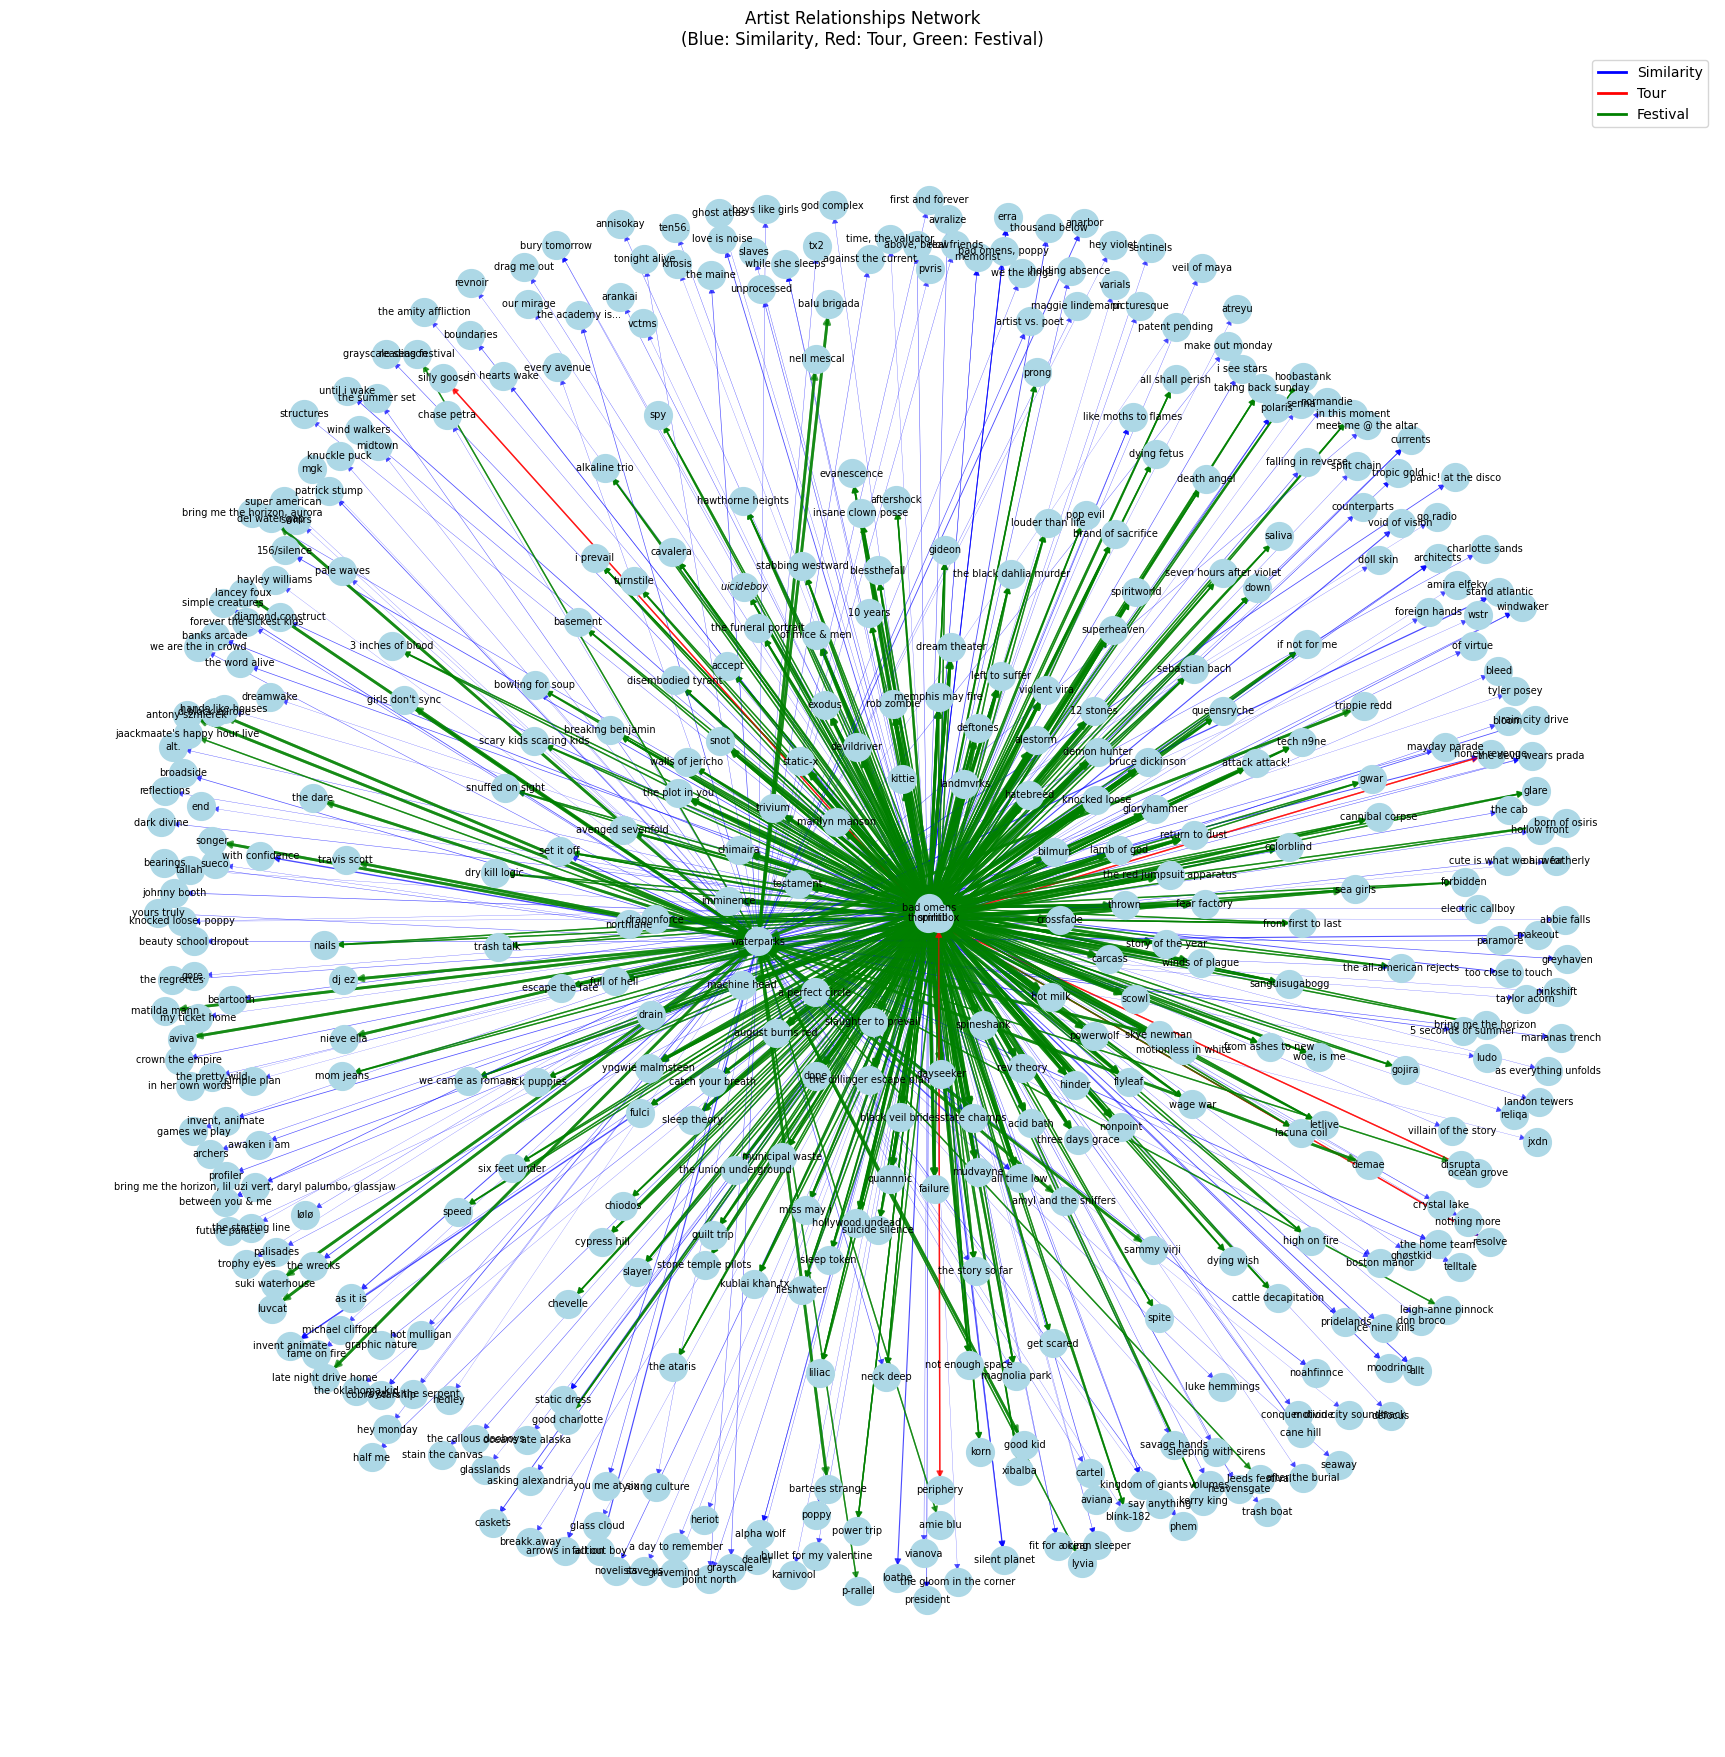

In [163]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
    
TOP_N_ARTISTS = None
NODE_SIZE = 400
FONT_SIZE = 7
FIGURE_SIZE = (22, 22)

with open("/home/jasmine/PROJECTS/riffnet/artist_relationships_subset.json", "r") as f:
    edges = json.load(f)

try:
    features_df = pd.read_csv("/home/jasmine/PROJECTS/riffnet/ALL_FEATURES_1010.csv")
    top_artists = set(features_df.nlargest(TOP_N_ARTISTS, "popularity")["name"]) if TOP_N_ARTISTS else None
except FileNotFoundError:
    top_artists = None

G = nx.DiGraph()  # Use DiGraph for similarity (asymmetric), will handle tour/festival as undirected\n",
for edge in edges:
    
    source = edge["origin"]
    target = edge["target"]
    edge_type = edge["type"].strip()
    weight = edge["weight"]
    
    # if top_artists and (source not in top_artists or target not in top_artists):
    #     continue
    # For tour and festival edges, add both directions to simulate undirected edges\n",
    if edge_type in ["tour", "festival"]:
        G.add_edge(source, target, type=edge_type, weight=weight, **{k: v for k, v in edge.items() if k not in ["origin", "target", "type", "weight"]})
        G.add_edge(target, source, type=edge_type, weight=weight, **{k: v for k, v in edge.items() if k not in ["origin", "target", "type", "weight"]})
    elif edge_type == "similarity":  # Similarity edges are directed\n",
        G.add_edge(source, target, type=edge_type, weight=weight)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

edge_colors = {"tour": "red",
               "festival": "green",
               "similarity": "blue"}

edge_widths = [G[u][v]["weight"] * 1 for u, v in G.edges()]  # Scale weight for visibility\n",
edge_colors_list = [edge_colors[G[u][v]["type"]] for u, v in G.edges()]

pos = nx.spring_layout(G, k=0.5, iterations=50)
plt.figure(figsize=FIGURE_SIZE)
nx.draw_networkx_nodes(G, pos, node_size=NODE_SIZE, node_color="lightblue"),
nx.draw_networkx_edges(G, pos, edge_color=edge_colors_list, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=FONT_SIZE)
plt.title("Artist Relationships Network\n(Blue: Similarity, Red: Tour, Green: Festival)")
plt.axis("off")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color="blue", lw=2, label="Similarity"),
                   Line2D([0], [0], color="red", lw=2, label="Tour"),
                   Line2D([0], [0], color="green", lw=2, label="Festival")]
plt.legend(handles=legend_elements, loc="upper right")
plt.savefig("artist_relationships_subset.png")
plt.show()

In [136]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

In [138]:
def _get_spotify_artist_by_search(artist_names):

    """Retrieves artist-level Spotify features for a list of provided artist names 
       using Spotify's search function. For each query, the first match is returned.
       This should be used for any artist whose URI us unknown (i.e. they are 
       not in the playlist)."""

    #spotify_cache = self._load_cache("spotify_artist_cache.json")

    def fetch_search(artist_name):

        cache_key = artist_name.lower()
        # if cache_key in spotify_cache: 
        #     return spotify_cache[cache_key]["data"]

        try: 
            artist_info = SPOTIFY.search(q=artist_name, 
                                              type="artist").get("artists", {}).get("items", [])[0]
            
            artist_info["playlist_count"] = 0
            # spotify_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e: 
            
            print(f"_get_spotify_artist_by_search: no artist found for query {artist_name}; error {e}.")
            return {"name": cache_key, "uri": "", "genres": [], 
                    "popularity": 0, "followers": {"total": 0}, "playlist_count": 0}
    
    searched_artists = []

    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {executor.submit(fetch_search, name): name for name in artist_names if name}
        for future in as_completed(future_to_artist):
            result = future.result()
            if result:
                searched_artists.append(result)

    # for artist_name in artist_names:
       
    #     searched_artists.append(fetch_search(artist_name))
    
    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    
    # searched_artists = self._generate_discog_features(searched_artists)
    return searched_artists# self._get_spotify_features(searched_artists)

In [142]:
search = ["Thornhill", "Bad Omens", "Waterparks", "Spiritbox", "Loathe", "Sleep Token", "LANDMVRKS"]
start_time = time.time()
searched1 = _get_spotify_artist_by_search(search) 
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
print(searched1)

Total time: 0.51 seconds
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4MzJMcHQBl9SIYSjwWn8QW'}, 'followers': {'href': None, 'total': 934446}, 'genres': ['metalcore', 'djent', 'metal'], 'href': 'https://api.spotify.com/v1/artists/4MzJMcHQBl9SIYSjwWn8QW', 'id': '4MzJMcHQBl9SIYSjwWn8QW', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb501369c8b24b71bb2dcca603', 'height': 640, 'width': 640}, {'url': 'https://i.scdn.co/image/ab67616100005174501369c8b24b71bb2dcca603', 'height': 320, 'width': 320}, {'url': 'https://i.scdn.co/image/ab6761610000f178501369c8b24b71bb2dcca603', 'height': 160, 'width': 160}], 'name': 'Spiritbox', 'popularity': 69, 'type': 'artist', 'uri': 'spotify:artist:4MzJMcHQBl9SIYSjwWn8QW', 'playlist_count': 0}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/3QaxveoTiMetZCMp1sftiu'}, 'followers': {'href': None, 'total': 542052}, 'genres': ['pop punk'], 'href': 'https://api.spotify.com/v1/artists/3QaxveoTiMetZCMp1sftiu', 'id': '3Qa

In [140]:
def _get_spotify_artist_by_search2(artist_names):

    """Retrieves artist-level Spotify features for a list of provided artist names 
       using Spotify's search function. For each query, the first match is returned.
       This should be used for any artist whose URI us unknown (i.e. they are 
       not in the playlist)."""

    #spotify_cache = self._load_cache("spotify_artist_cache.json")

    def fetch_search(artist_name):

        cache_key = artist_name.lower()
        # if cache_key in spotify_cache: 
        #     return spotify_cache[cache_key]["data"]

        try: 
            artist_info = SPOTIFY.search(q=artist_name, 
                                              type="artist").get("artists", {}).get("items", [])[0]
            
            artist_info["playlist_count"] = 0
            # spotify_cache[cache_key] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e: 
            
            print(f"_get_spotify_artist_by_search: no artist found for query {artist_name}; error {e}.")
            return {"name": cache_key, "uri": "", "genres": [], 
                    "popularity": 0, "followers": {"total": 0}, "playlist_count": 0}
    
    searched_artists = []

    # with ThreadPoolExecutor(max_workers=5) as executor:
    #     future_to_artist = {executor.submit(fetch_search, name): name for name in artist_names if name}
    #     for future in as_completed(future_to_artist):
    #         result = future.result()
    #         if result:
    #             searched_artists.append(result)

    for artist_name in artist_names:
       
        searched_artists.append(fetch_search(artist_name))
    
    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    
    # searched_artists = self._generate_discog_features(searched_artists)
    return searched_artists# self._get_spotify_features(searched_artists)

In [143]:
search = ["Thornhill", "Bad Omens", "Waterparks", "Spiritbox", "Loathe", "Sleep Token", "LANDMVRKS"]
start_time = time.time()
searched2 = _get_spotify_artist_by_search2(search) 
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
print(searched2)

Total time: 1.86 seconds
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD'}, 'followers': {'href': None, 'total': 162722}, 'genres': ['metalcore', 'djent'], 'href': 'https://api.spotify.com/v1/artists/2dE5audbkV3o5cKxvM7lBD', 'id': '2dE5audbkV3o5cKxvM7lBD', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb1b292d70780f166fd776b295', 'height': 640, 'width': 640}, {'url': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295', 'height': 320, 'width': 320}, {'url': 'https://i.scdn.co/image/ab6761610000f1781b292d70780f166fd776b295', 'height': 160, 'width': 160}], 'name': 'Thornhill', 'popularity': 57, 'type': 'artist', 'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD', 'playlist_count': 0}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'}, 'followers': {'href': None, 'total': 1783958}, 'genres': ['metalcore'], 'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V', 'id': '3Ri4H12KFy

In [160]:
response = SPOTIFY.playlist_tracks("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=168d042b351248b3", offset=0)
    # each artist involved in a song with features is considered individually
    # might be a better idea to only consider primary artists...we will see
# response["items"]
# [artist_dict for track in response["items"] for artist_dict in track["track"]["artists"][0]]
[track["track"]["artists"][0] for track in response["items"]]
# response["items"]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artis

In [150]:
def _get_playlist_artists(): 

    """Retrieves artist-level data for each unique artist in the provided 
       playlist."""    

    # grab tracks in playlist
    response = SPOTIFY.playlist_tracks("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=168d042b351248b3", offset=0)
    # each artist involved in a song with features is considered individually
    # might be a better idea to only consider primary artists...we will see
    artists = [artist_dict for track in response["items"] 
               for artist_dict in track["track"]["artists"]]
    # total number of tracks on playlist - needed to determine the number 
    # of loops (max tracks per req. is 100)
    total = response["total"]

    # for larger playlists, multiple requests need to be made to fetch all tracks
    for offset in range(100, total + 1, 100): 

        response = SPOTIFY.playlist_tracks("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=168d042b351248b3", offset=offset)
        artists += [artist_dict for track in response["items"] 
                    for artist_dict in track["track"]["artists"]]
    
    # set of unique names and URIs
    artist_identifiers = set([(artist["name"].lower(), 
                               artist["uri"]) for artist in artists])
    all_artist_info = []

    # spotify_cache = self._load_cache("spotify_artist_cache.json")
    
    def fetch_artist(uri, name):

        # if name in spotify_cache:

        #     return spotify_cache[name]["data"]
        
        try:
            artist_info = SPOTIFY.artist(uri)
            artist_count = sum(1 for artist_dict in artists if artist_dict["uri"] == uri)
            artist_info["playlist_count"] = artist_count
            # spotify_cache[name.lower()] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e:
            print(f"_get_playlist_artists: Error for URI {uri}: {e}")
            return None

    # for (name, uri) in artist_identifiers: 
    #     all_artist_info.append(fetch_artist(uri, name))

    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {executor.submit(fetch_artist, uri, name): (name, uri) for (name, uri) in artist_identifiers}
        for future in as_completed(future_to_artist):
            result = future.result()
            if result:
                all_artist_info.append(result)

    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    print(f"_get_playlist_artists: information retrieved for {len(artist_identifiers)} artists.")
    
    # all_artist_info = self._generate_discog_features(all_artist_info)
    return all_artist_info# self._get_spotify_features(all_artist_info)

In [151]:
start_time = time.time()
info = _get_playlist_artists() 
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
print(info)

_get_playlist_artists: information retrieved for 80 artists.
Total time: 3.57 seconds
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3TOqt5oJwL9BE2NG9MEwDa'}, 'followers': {'href': None, 'total': 7481574}, 'genres': ['metal', 'nu metal', 'alternative metal', 'rap metal', 'hard rock', 'rock'], 'href': 'https://api.spotify.com/v1/artists/3TOqt5oJwL9BE2NG9MEwDa', 'id': '3TOqt5oJwL9BE2NG9MEwDa', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb6823b6df396ecf49931e34a1', 'height': 640, 'width': 640}, {'url': 'https://i.scdn.co/image/ab676161000051746823b6df396ecf49931e34a1', 'height': 320, 'width': 320}, {'url': 'https://i.scdn.co/image/ab6761610000f1786823b6df396ecf49931e34a1', 'height': 160, 'width': 160}], 'name': 'Disturbed', 'popularity': 79, 'type': 'artist', 'uri': 'spotify:artist:3TOqt5oJwL9BE2NG9MEwDa', 'playlist_count': 1}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/1VW5tZ9pmSb2rG0GmSELwW'}, 'followers': {'href': None, 'total': 23052

In [152]:
def _get_playlist_artists2(): 

    """Retrieves artist-level data for each unique artist in the provided 
       playlist."""    

    # grab tracks in playlist
    response = SPOTIFY.playlist_tracks("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=168d042b351248b3", offset=0)
    # each artist involved in a song with features is considered individually
    # might be a better idea to only consider primary artists...we will see
    artists = [artist_dict for track in response["items"] 
               for artist_dict in track["track"]["artists"]]
    # total number of tracks on playlist - needed to determine the number 
    # of loops (max tracks per req. is 100)
    total = response["total"]

    # for larger playlists, multiple requests need to be made to fetch all tracks
    for offset in range(100, total + 1, 100): 

        response = SPOTIFY.playlist_tracks("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=168d042b351248b3", offset=offset)
        artists += [artist_dict for track in response["items"] 
                    for artist_dict in track["track"]["artists"]]
    
    # set of unique names and URIs
    artist_identifiers = set([(artist["name"].lower(), 
                               artist["uri"]) for artist in artists])
    all_artist_info = []

    # spotify_cache = self._load_cache("spotify_artist_cache.json")
    
    def fetch_artist(uri, name):

        # if name in spotify_cache:

        #     return spotify_cache[name]["data"]
        
        try:
            artist_info = SPOTIFY.artist(uri)
            artist_count = sum(1 for artist_dict in artists if artist_dict["uri"] == uri)
            artist_info["playlist_count"] = artist_count
            # spotify_cache[name.lower()] = {"data": artist_info, "timestamp": datetime.now().timestamp()}

            return artist_info
        
        except Exception as e:
            print(f"_get_playlist_artists: Error for URI {uri}: {e}")
            return None

    for (name, uri) in artist_identifiers: 
        all_artist_info.append(fetch_artist(uri, name))

    # with ThreadPoolExecutor(max_workers=5) as executor:
    #     future_to_artist = {executor.submit(fetch_artist, uri, name): (name, uri) for (name, uri) in artist_identifiers}
    #     for future in as_completed(future_to_artist):
    #         result = future.result()
    #         if result:
    #             all_artist_info.append(result)

    # self._save_cache(spotify_cache, "spotify_artist_cache.json")
    print(f"_get_playlist_artists: information retrieved for {len(artist_identifiers)} artists.")
    
    # all_artist_info = self._generate_discog_features(all_artist_info)
    return all_artist_info# self._get_spotify_features(all_artist_info)

In [153]:
start_time = time.time()
info = _get_playlist_artists2() 
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
print(info)

_get_playlist_artists: information retrieved for 80 artists.
Total time: 7.84 seconds
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3TOqt5oJwL9BE2NG9MEwDa'}, 'followers': {'href': None, 'total': 7481574}, 'genres': ['metal', 'nu metal', 'alternative metal', 'rap metal', 'hard rock', 'rock'], 'href': 'https://api.spotify.com/v1/artists/3TOqt5oJwL9BE2NG9MEwDa', 'id': '3TOqt5oJwL9BE2NG9MEwDa', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb6823b6df396ecf49931e34a1', 'height': 640, 'width': 640}, {'url': 'https://i.scdn.co/image/ab676161000051746823b6df396ecf49931e34a1', 'height': 320, 'width': 320}, {'url': 'https://i.scdn.co/image/ab6761610000f1786823b6df396ecf49931e34a1', 'height': 160, 'width': 160}], 'name': 'Disturbed', 'popularity': 79, 'type': 'artist', 'uri': 'spotify:artist:3TOqt5oJwL9BE2NG9MEwDa', 'playlist_count': 1}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/6noBlZq0a76b6Iq6k726cH'}, 'followers': {'href': None, 'total': 65}, 

Graph created with 95 nodes and 429 edges.


/tmp/ipykernel_185808/1680591610.py:49: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors_list, width=edge_widths, alpha=0.7)


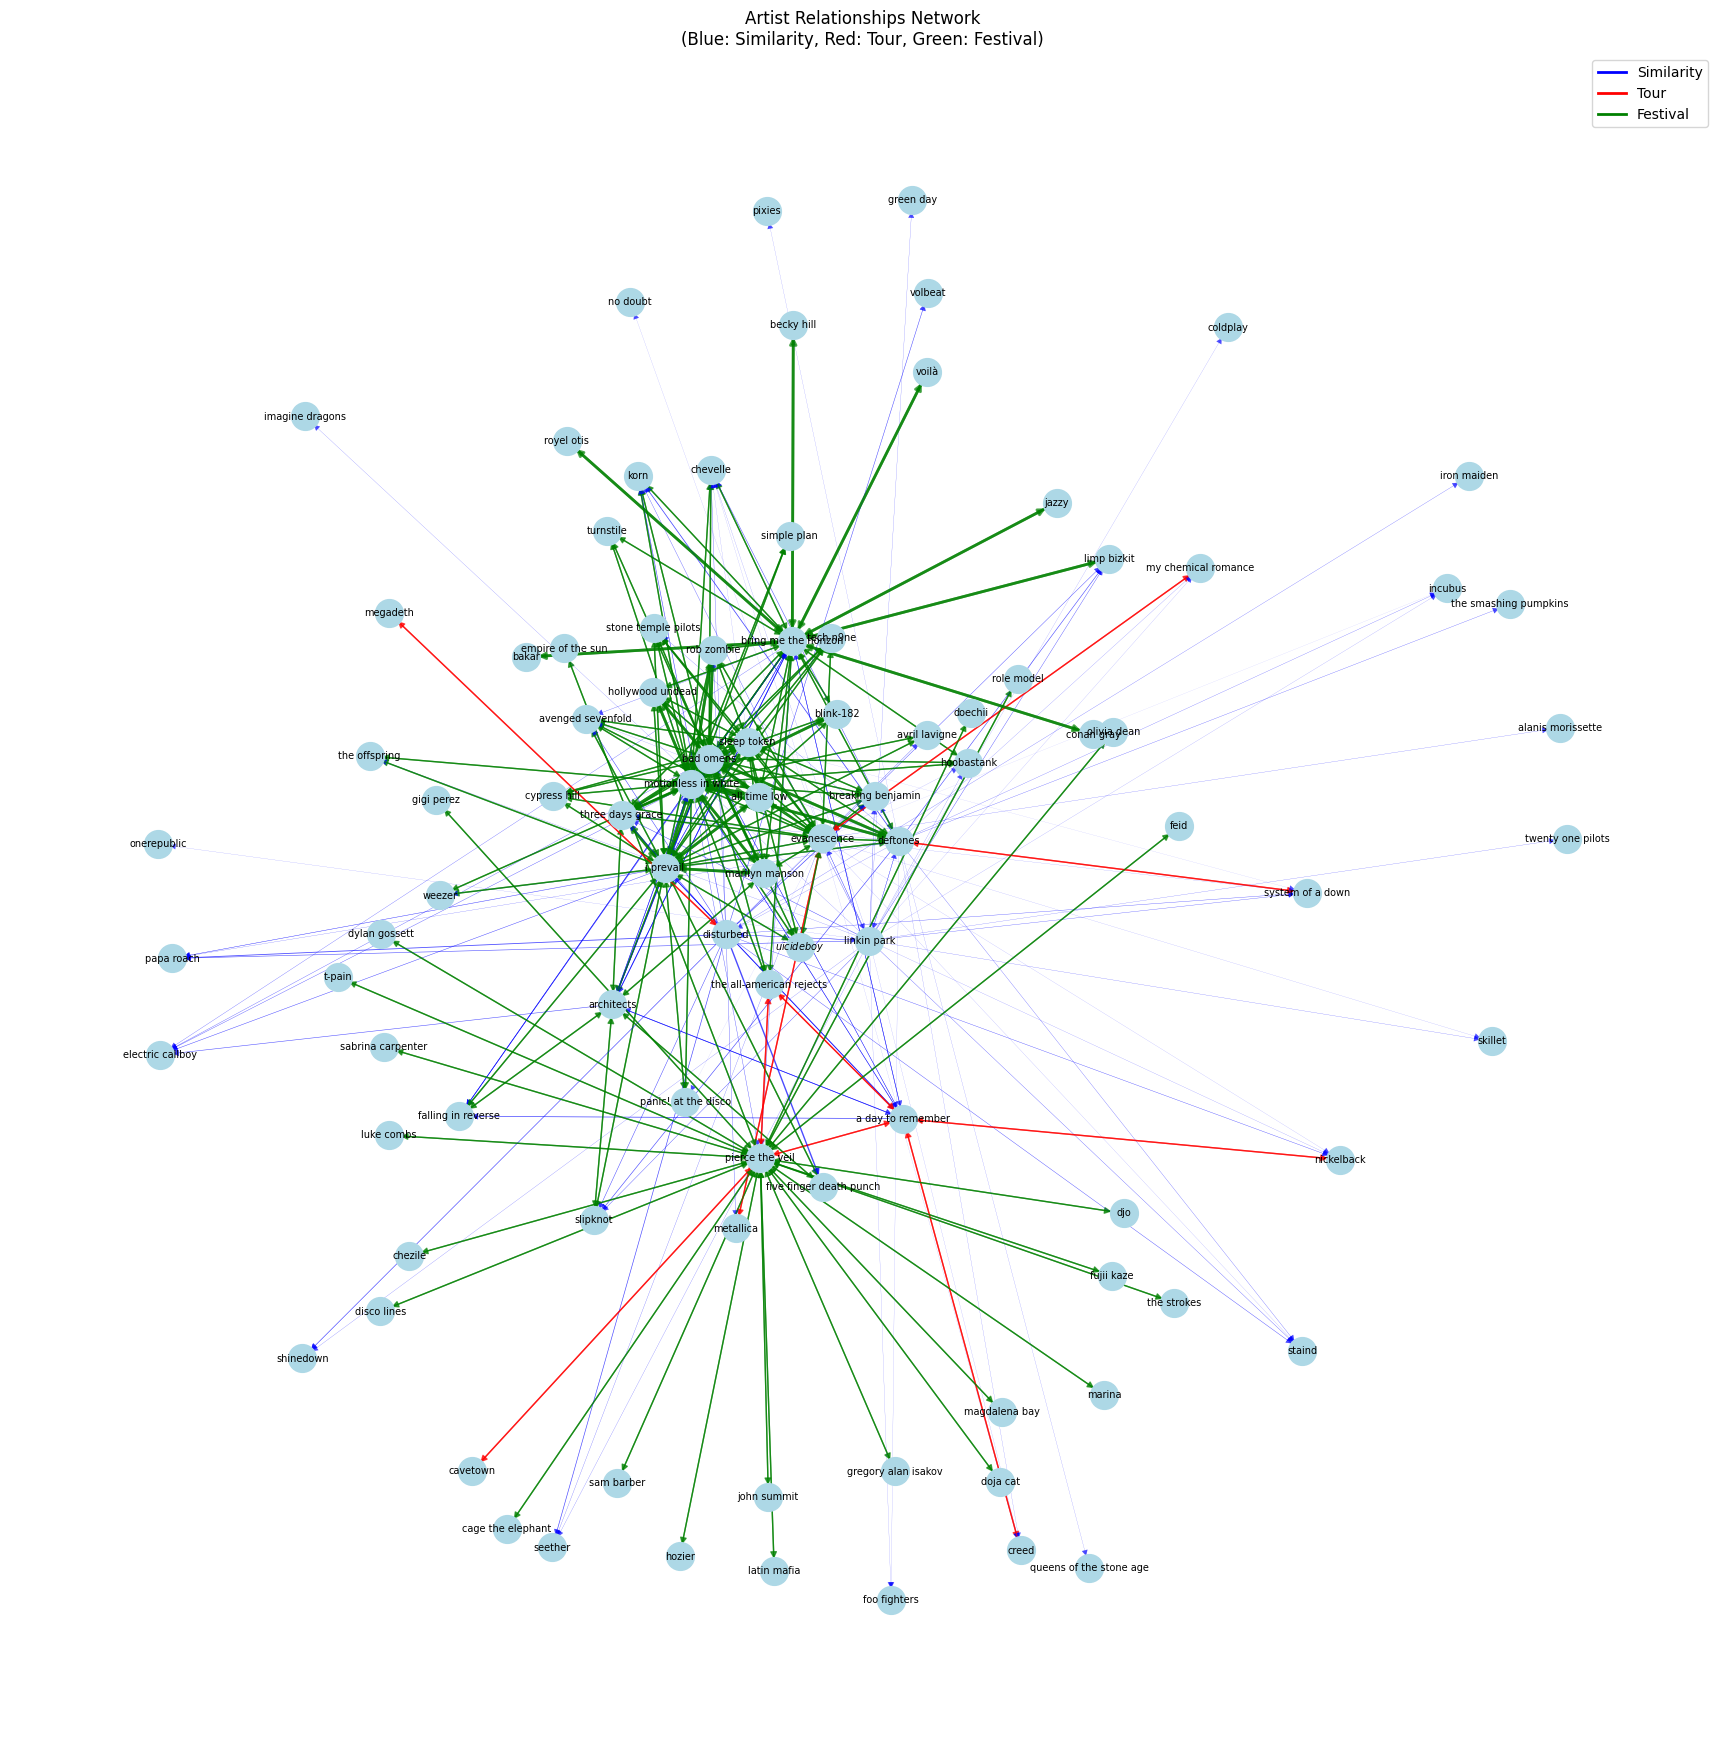

In [169]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
    
TOP_N_ARTISTS = 120
NODE_SIZE = 400
FONT_SIZE = 7
FIGURE_SIZE = (22, 22)

with open("/home/jasmine/PROJECTS/riffnet/artist_relationships.json", "r") as f:
    edges = json.load(f)

try:
    features_df = pd.read_csv("/home/jasmine/PROJECTS/riffnet/ALL_FEATURES_HARDNHEAVY.csv")
    top_artists = set(features_df.nlargest(TOP_N_ARTISTS, "popularity")["name"]) if TOP_N_ARTISTS else None
except FileNotFoundError:
    top_artists = None

G = nx.DiGraph()  # Use DiGraph for similarity (asymmetric), will handle tour/festival as undirected\n",
for edge in edges:
    
    source = edge["origin"]
    target = edge["target"]
    edge_type = edge["type"].strip()
    weight = edge["weight"]
    
    if top_artists and (source not in top_artists or target not in top_artists):
        continue
    # For tour and festival edges, add both directions to simulate undirected edges\n",
    if edge_type in ["tour", "festival"]:
        G.add_edge(source, target, type=edge_type, weight=weight, **{k: v for k, v in edge.items() if k not in ["origin", "target", "type", "weight"]})
        G.add_edge(target, source, type=edge_type, weight=weight, **{k: v for k, v in edge.items() if k not in ["origin", "target", "type", "weight"]})
    elif edge_type == "similarity":  # Similarity edges are directed\n",
        G.add_edge(source, target, type=edge_type, weight=weight)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

edge_colors = {"tour": "red",
               "festival": "green",
               "similarity": "blue"}

edge_widths = [G[u][v]["weight"] * 1 for u, v in G.edges()]  # Scale weight for visibility\n",
edge_colors_list = [edge_colors[G[u][v]["type"]] for u, v in G.edges()]

pos = nx.spring_layout(G, k=0.5, iterations=50)
plt.figure(figsize=FIGURE_SIZE)
nx.draw_networkx_nodes(G, pos, node_size=NODE_SIZE, node_color="lightblue"),
nx.draw_networkx_edges(G, pos, edge_color=edge_colors_list, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=FONT_SIZE)
plt.title("Artist Relationships Network\n(Blue: Similarity, Red: Tour, Green: Festival)")
plt.axis("off")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color="blue", lw=2, label="Similarity"),
                   Line2D([0], [0], color="red", lw=2, label="Tour"),
                   Line2D([0], [0], color="green", lw=2, label="Festival")]
plt.legend(handles=legend_elements, loc="upper right")
plt.savefig("artist_relationships.png")
plt.show()